In [1]:
import os
import pandas as pd
import numpy as np
import glob
from obspy.io.sac.sactrace import SACTrace
import pygmt
from pygmt.clib import Session
from obspy.taup import TauPyModel

In [2]:
root_dir = "/home/elemento/Music/Processing/Download_NSFE"
os.listdir(root_dir)

['IRIS', 'GFZ']

In [3]:
# Define catalog duration
year1 = 2021
year2 = 2022

# Define stations provider
provider = "GFZ" 

data_sac = f"{root_dir}/{provider}/{year1}"

For Event: 20210427164310654


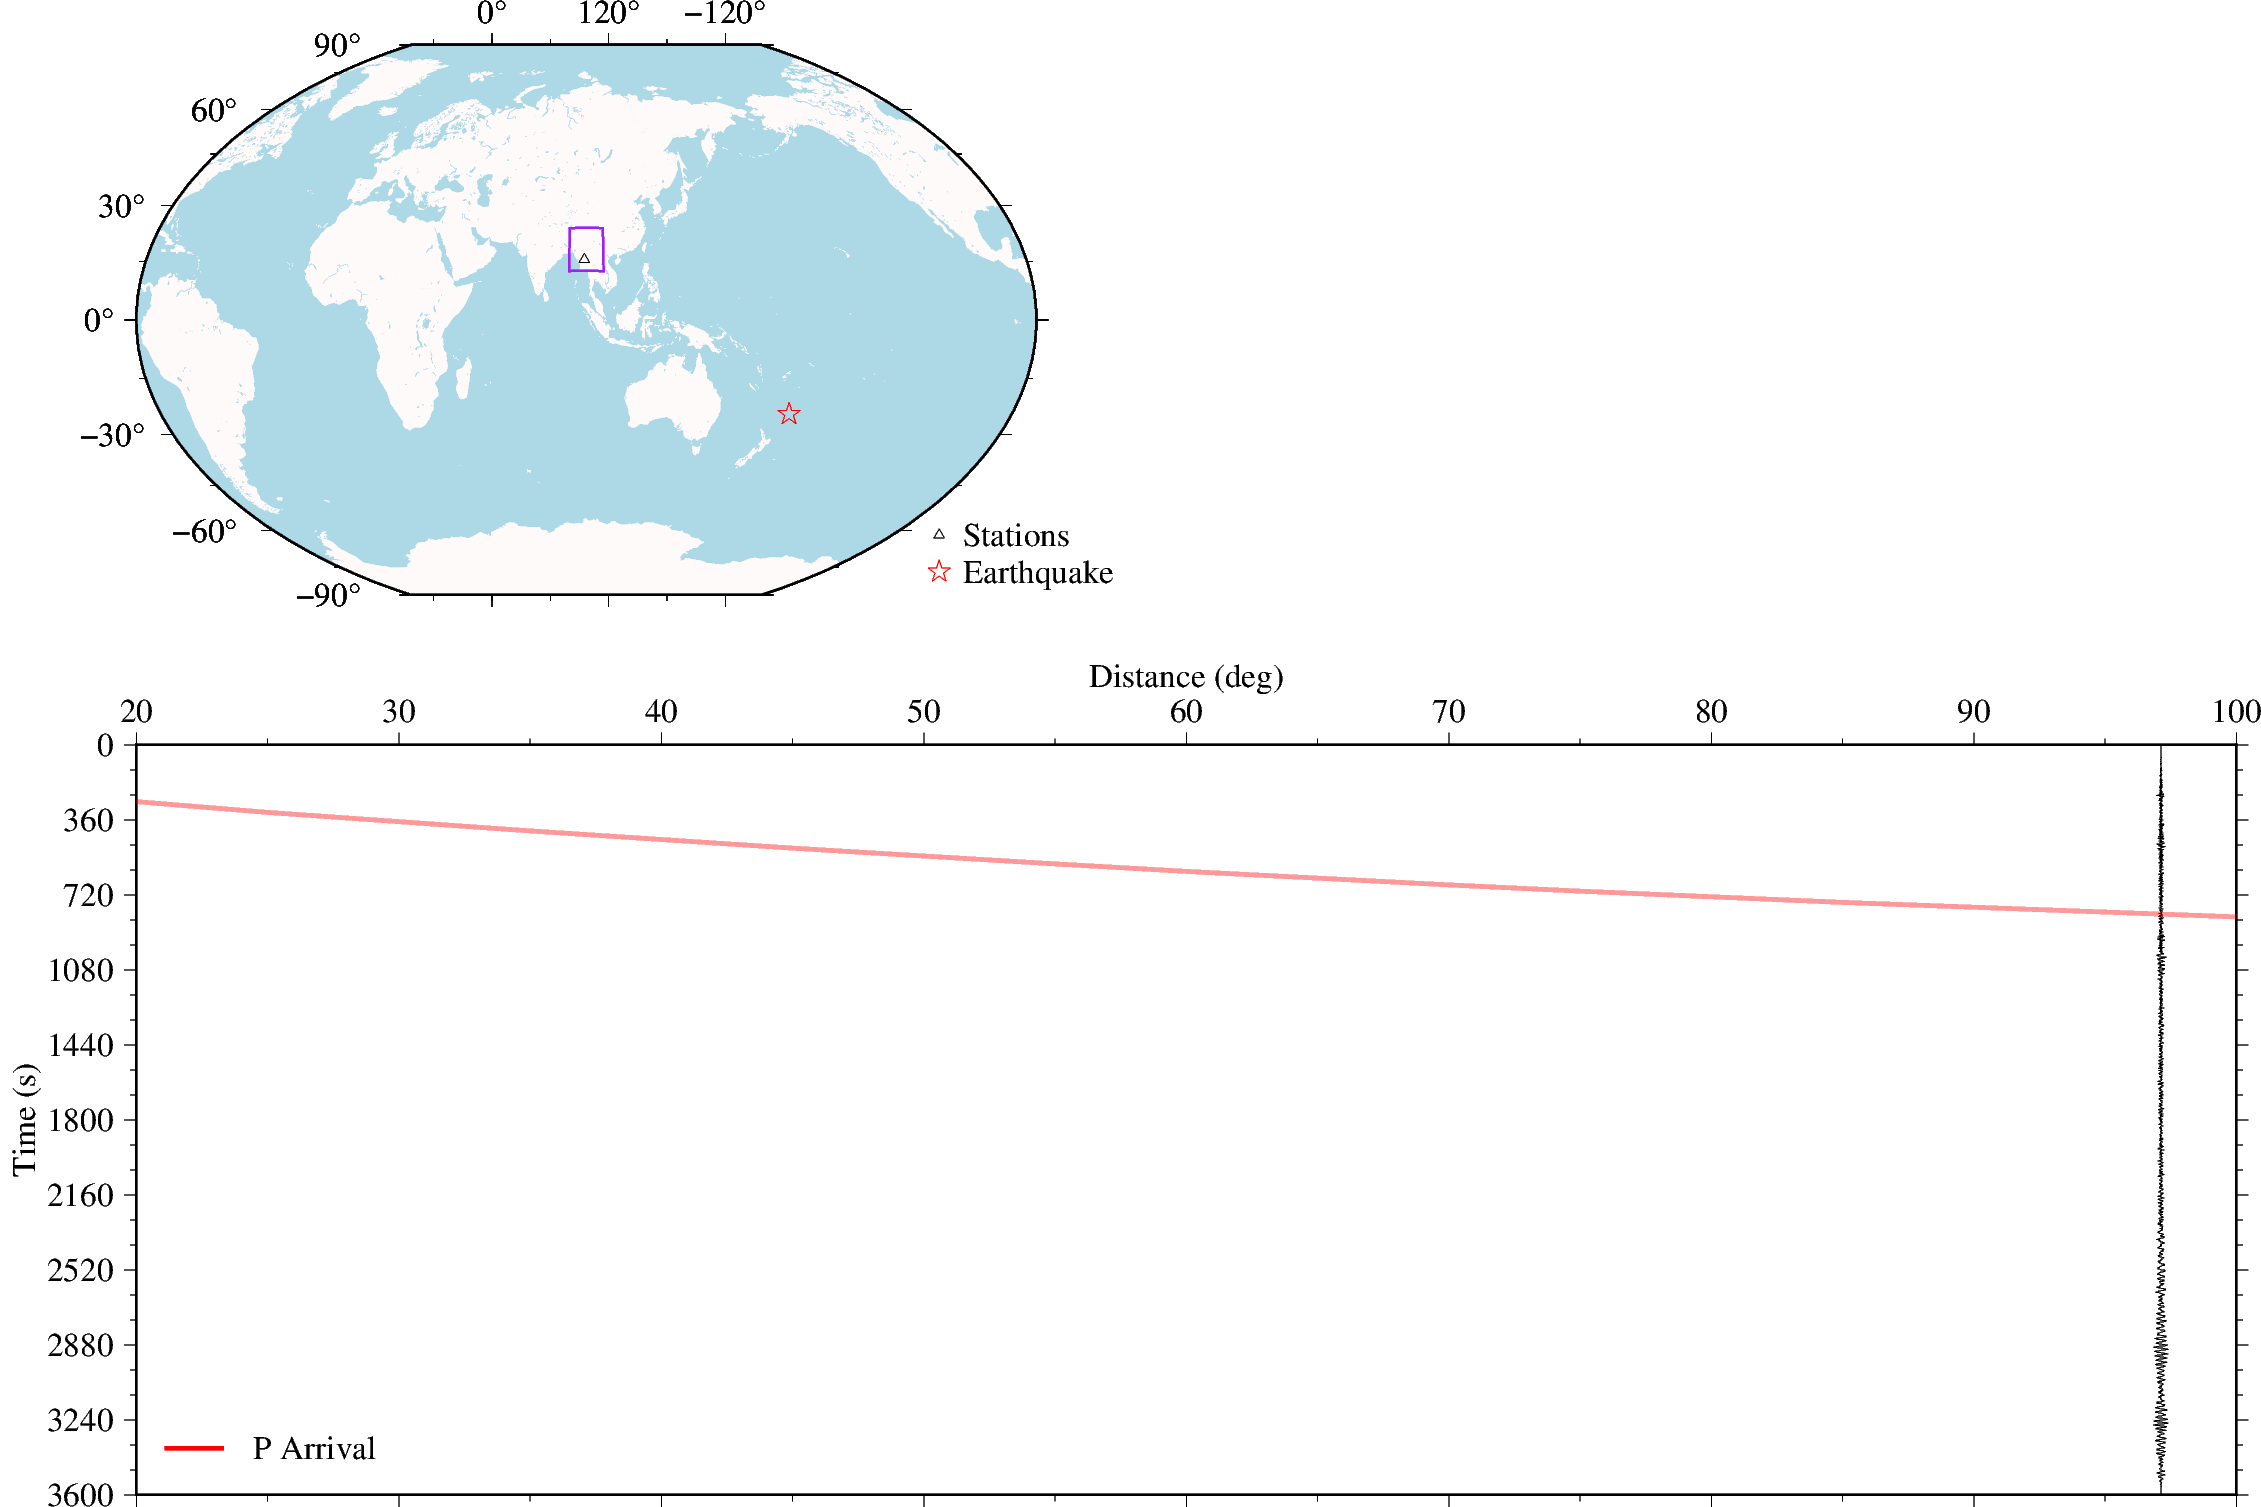

For Event: 20210309214620243


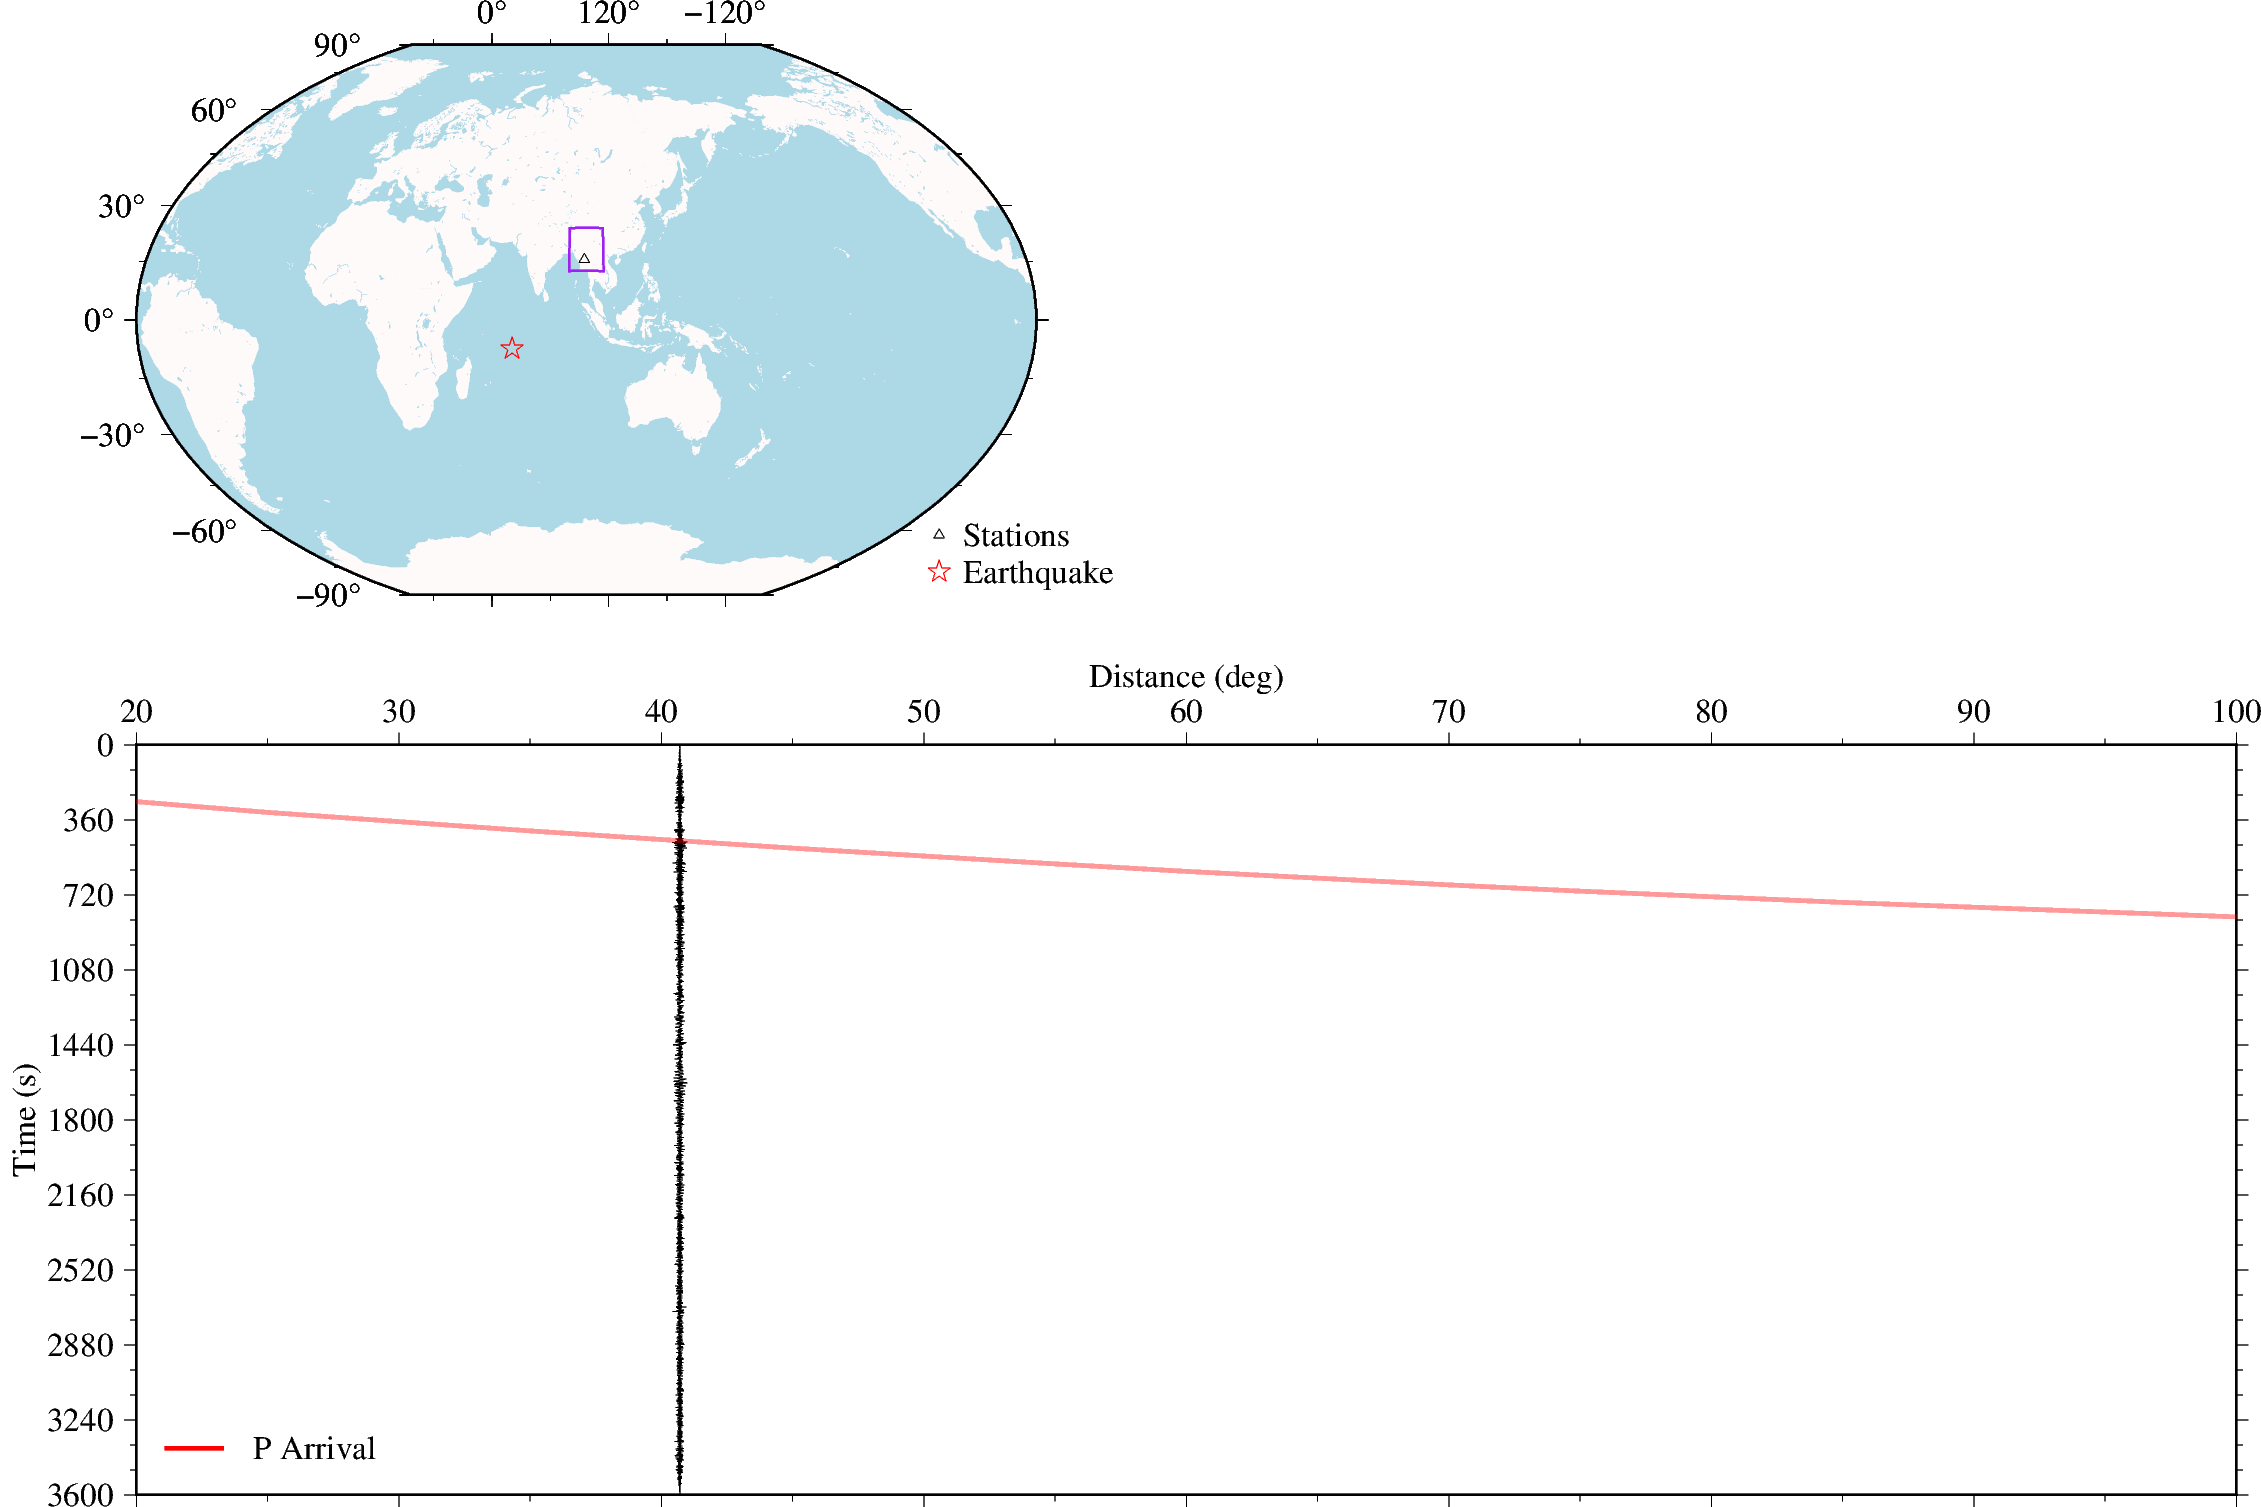

For Event: 20210307165313829


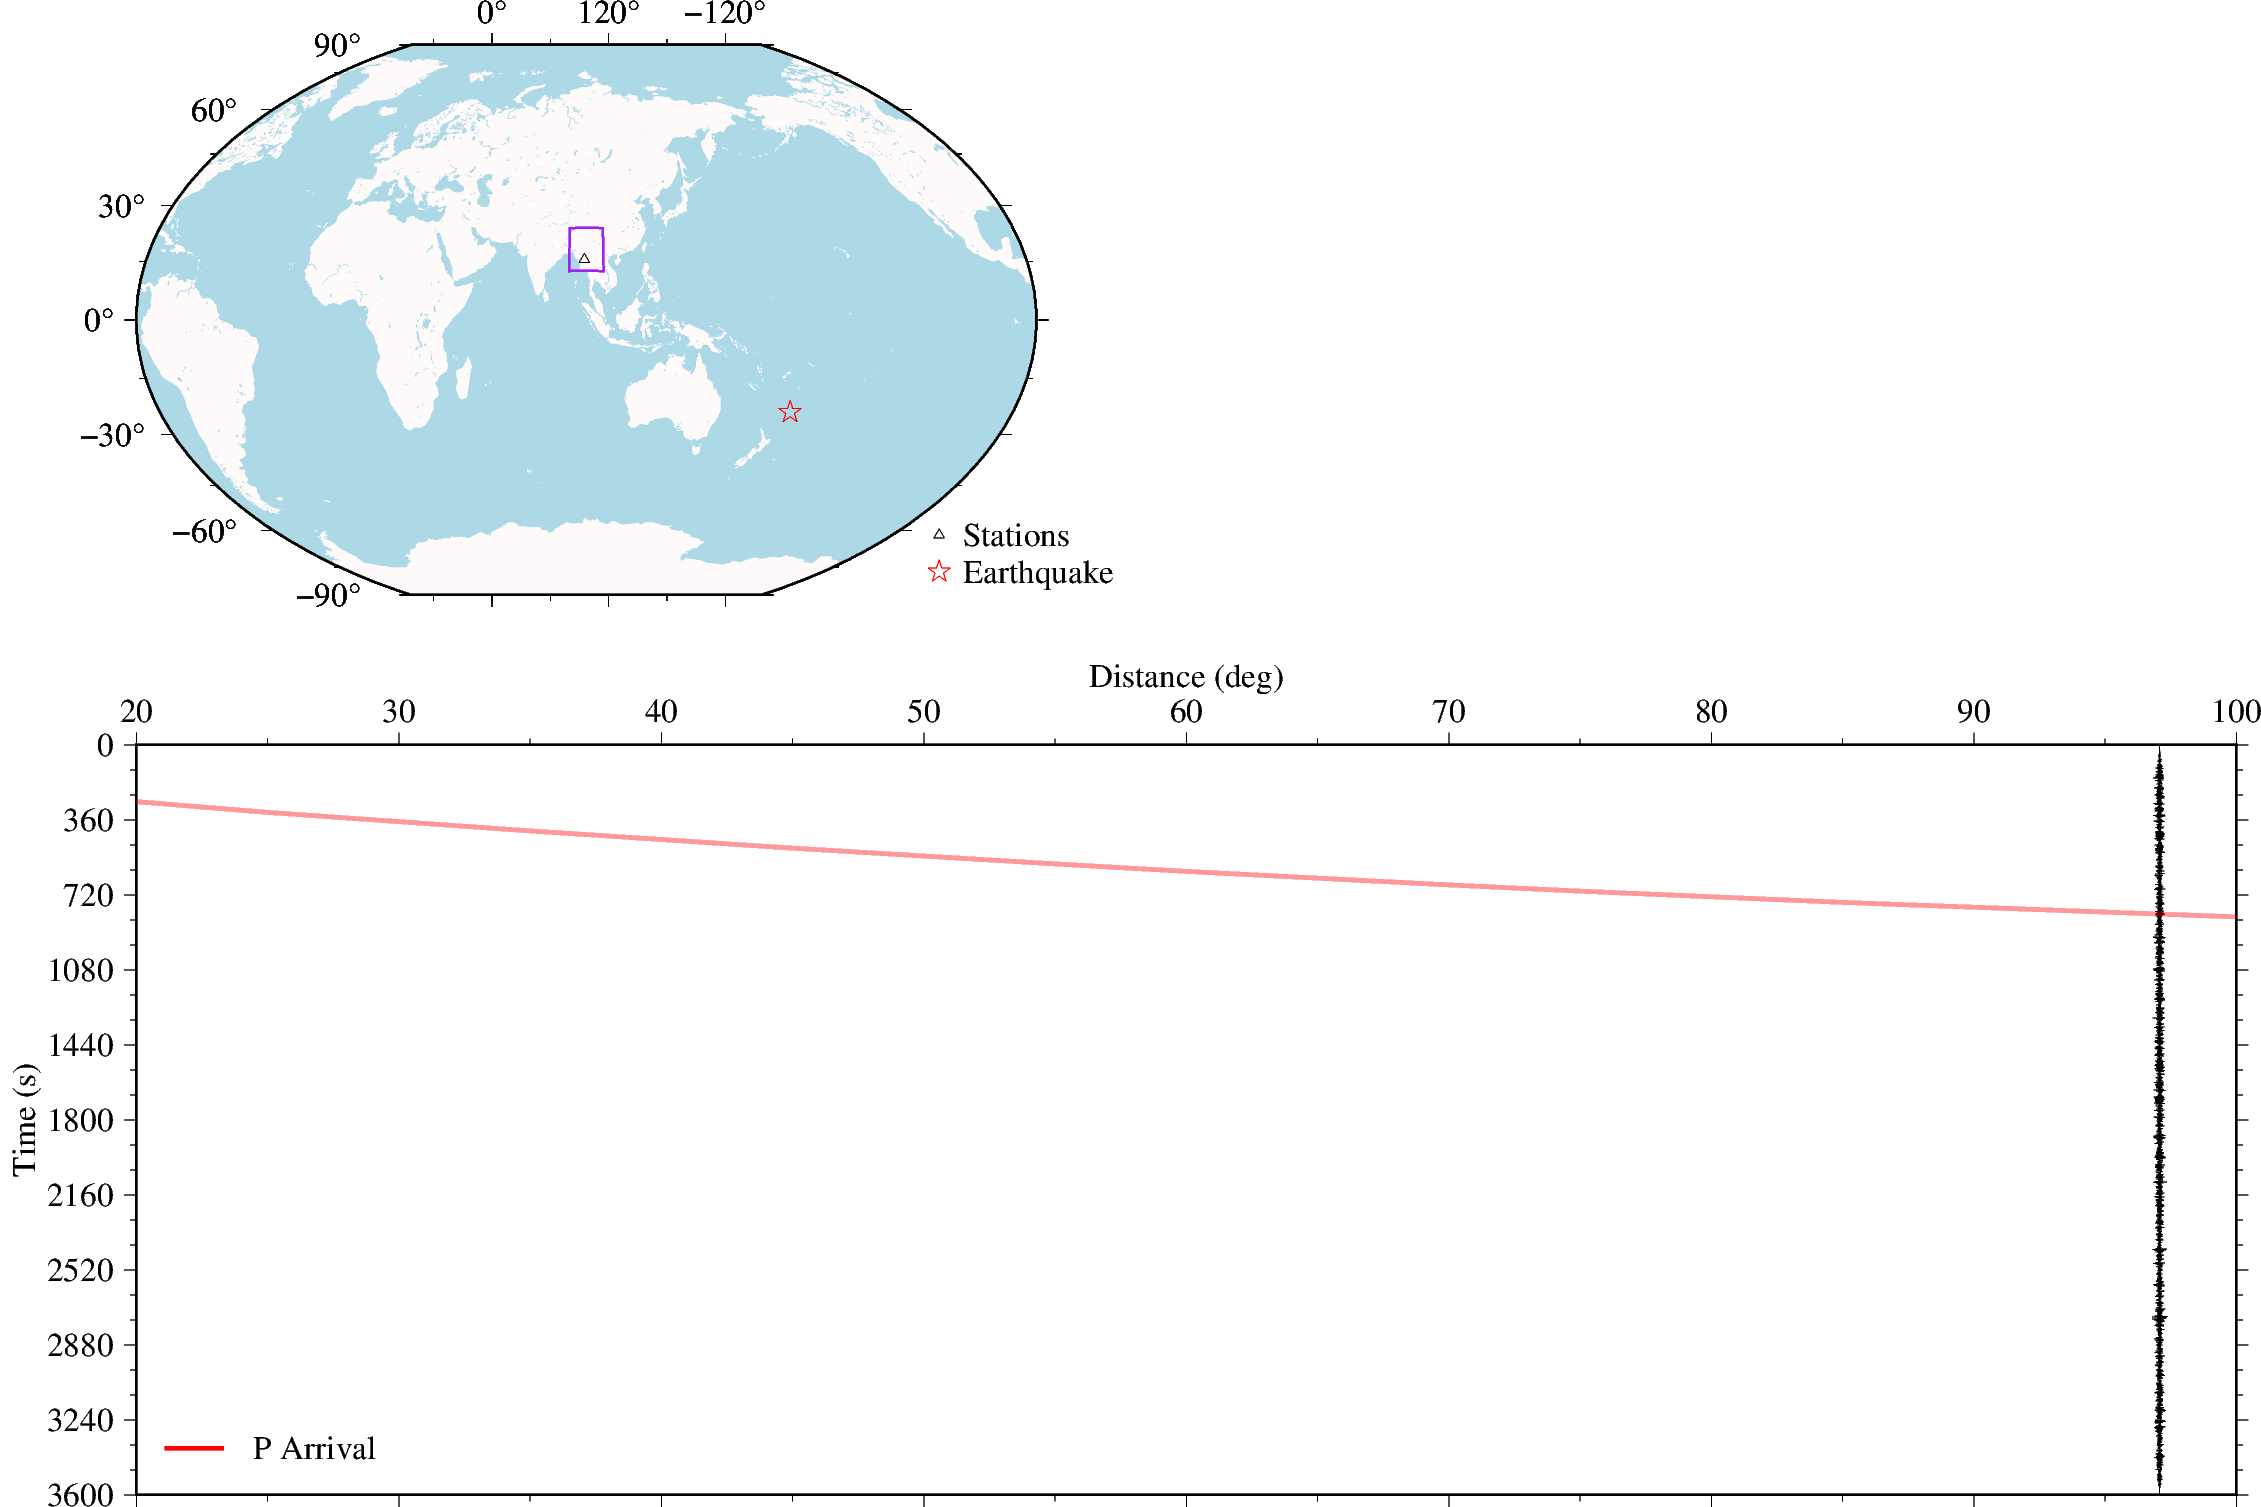

For Event: 20210708100917725


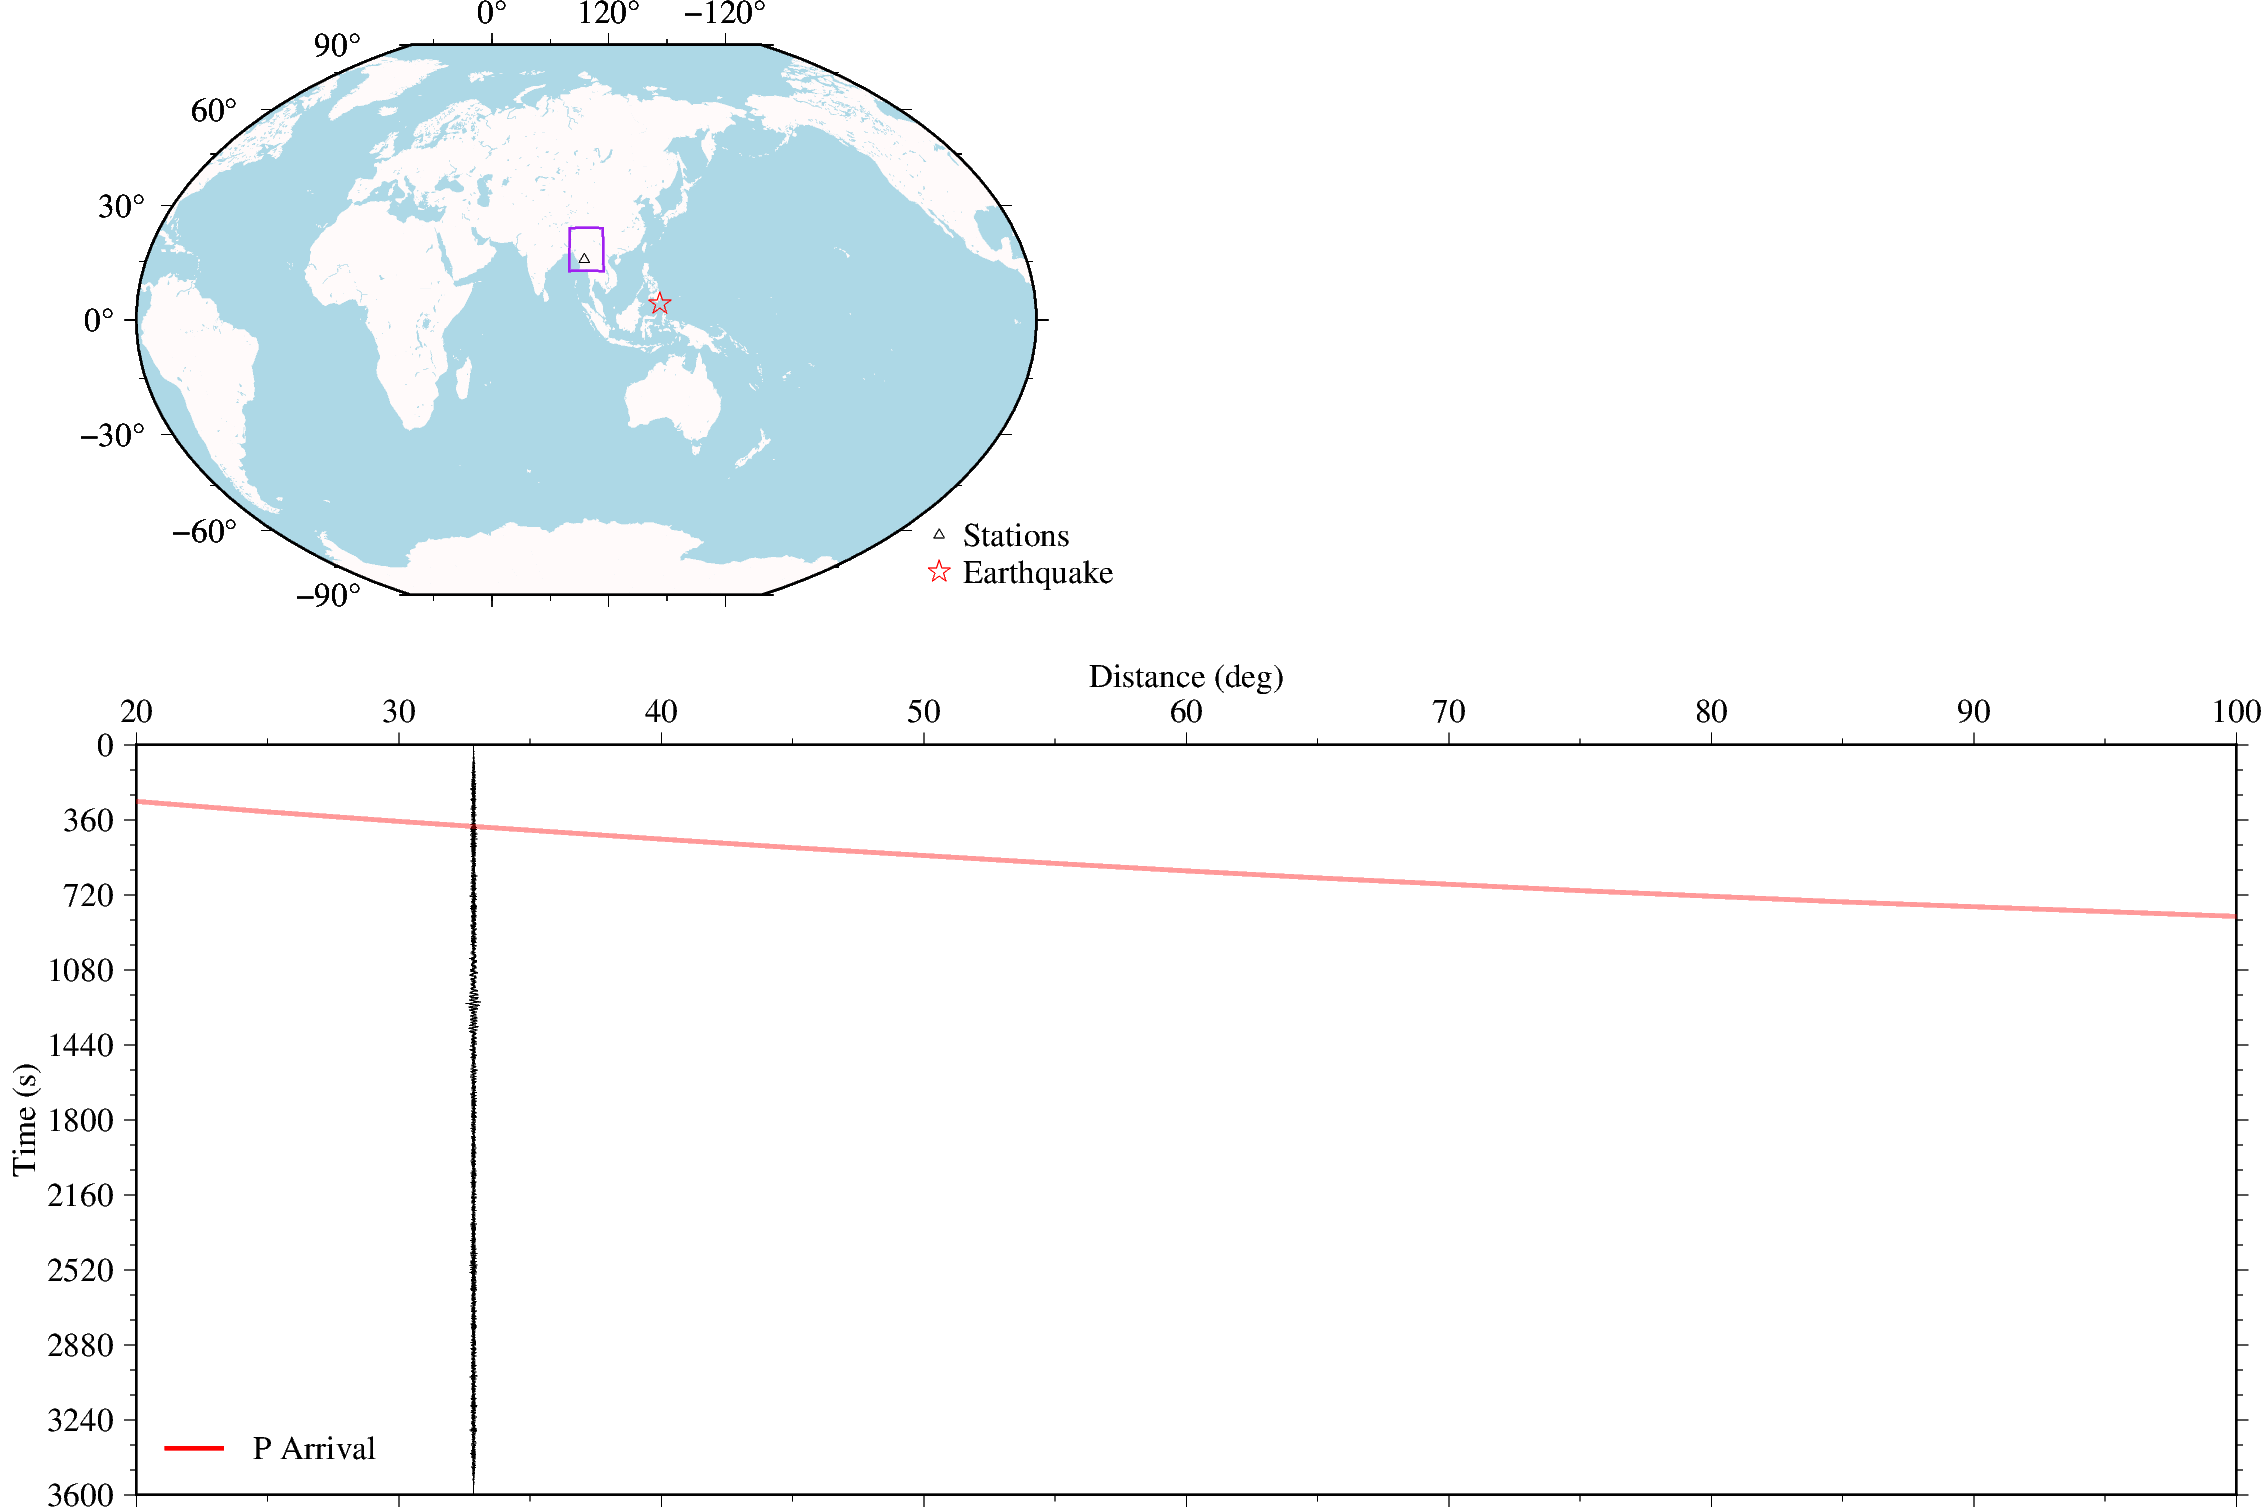

For Event: 20210305071955313


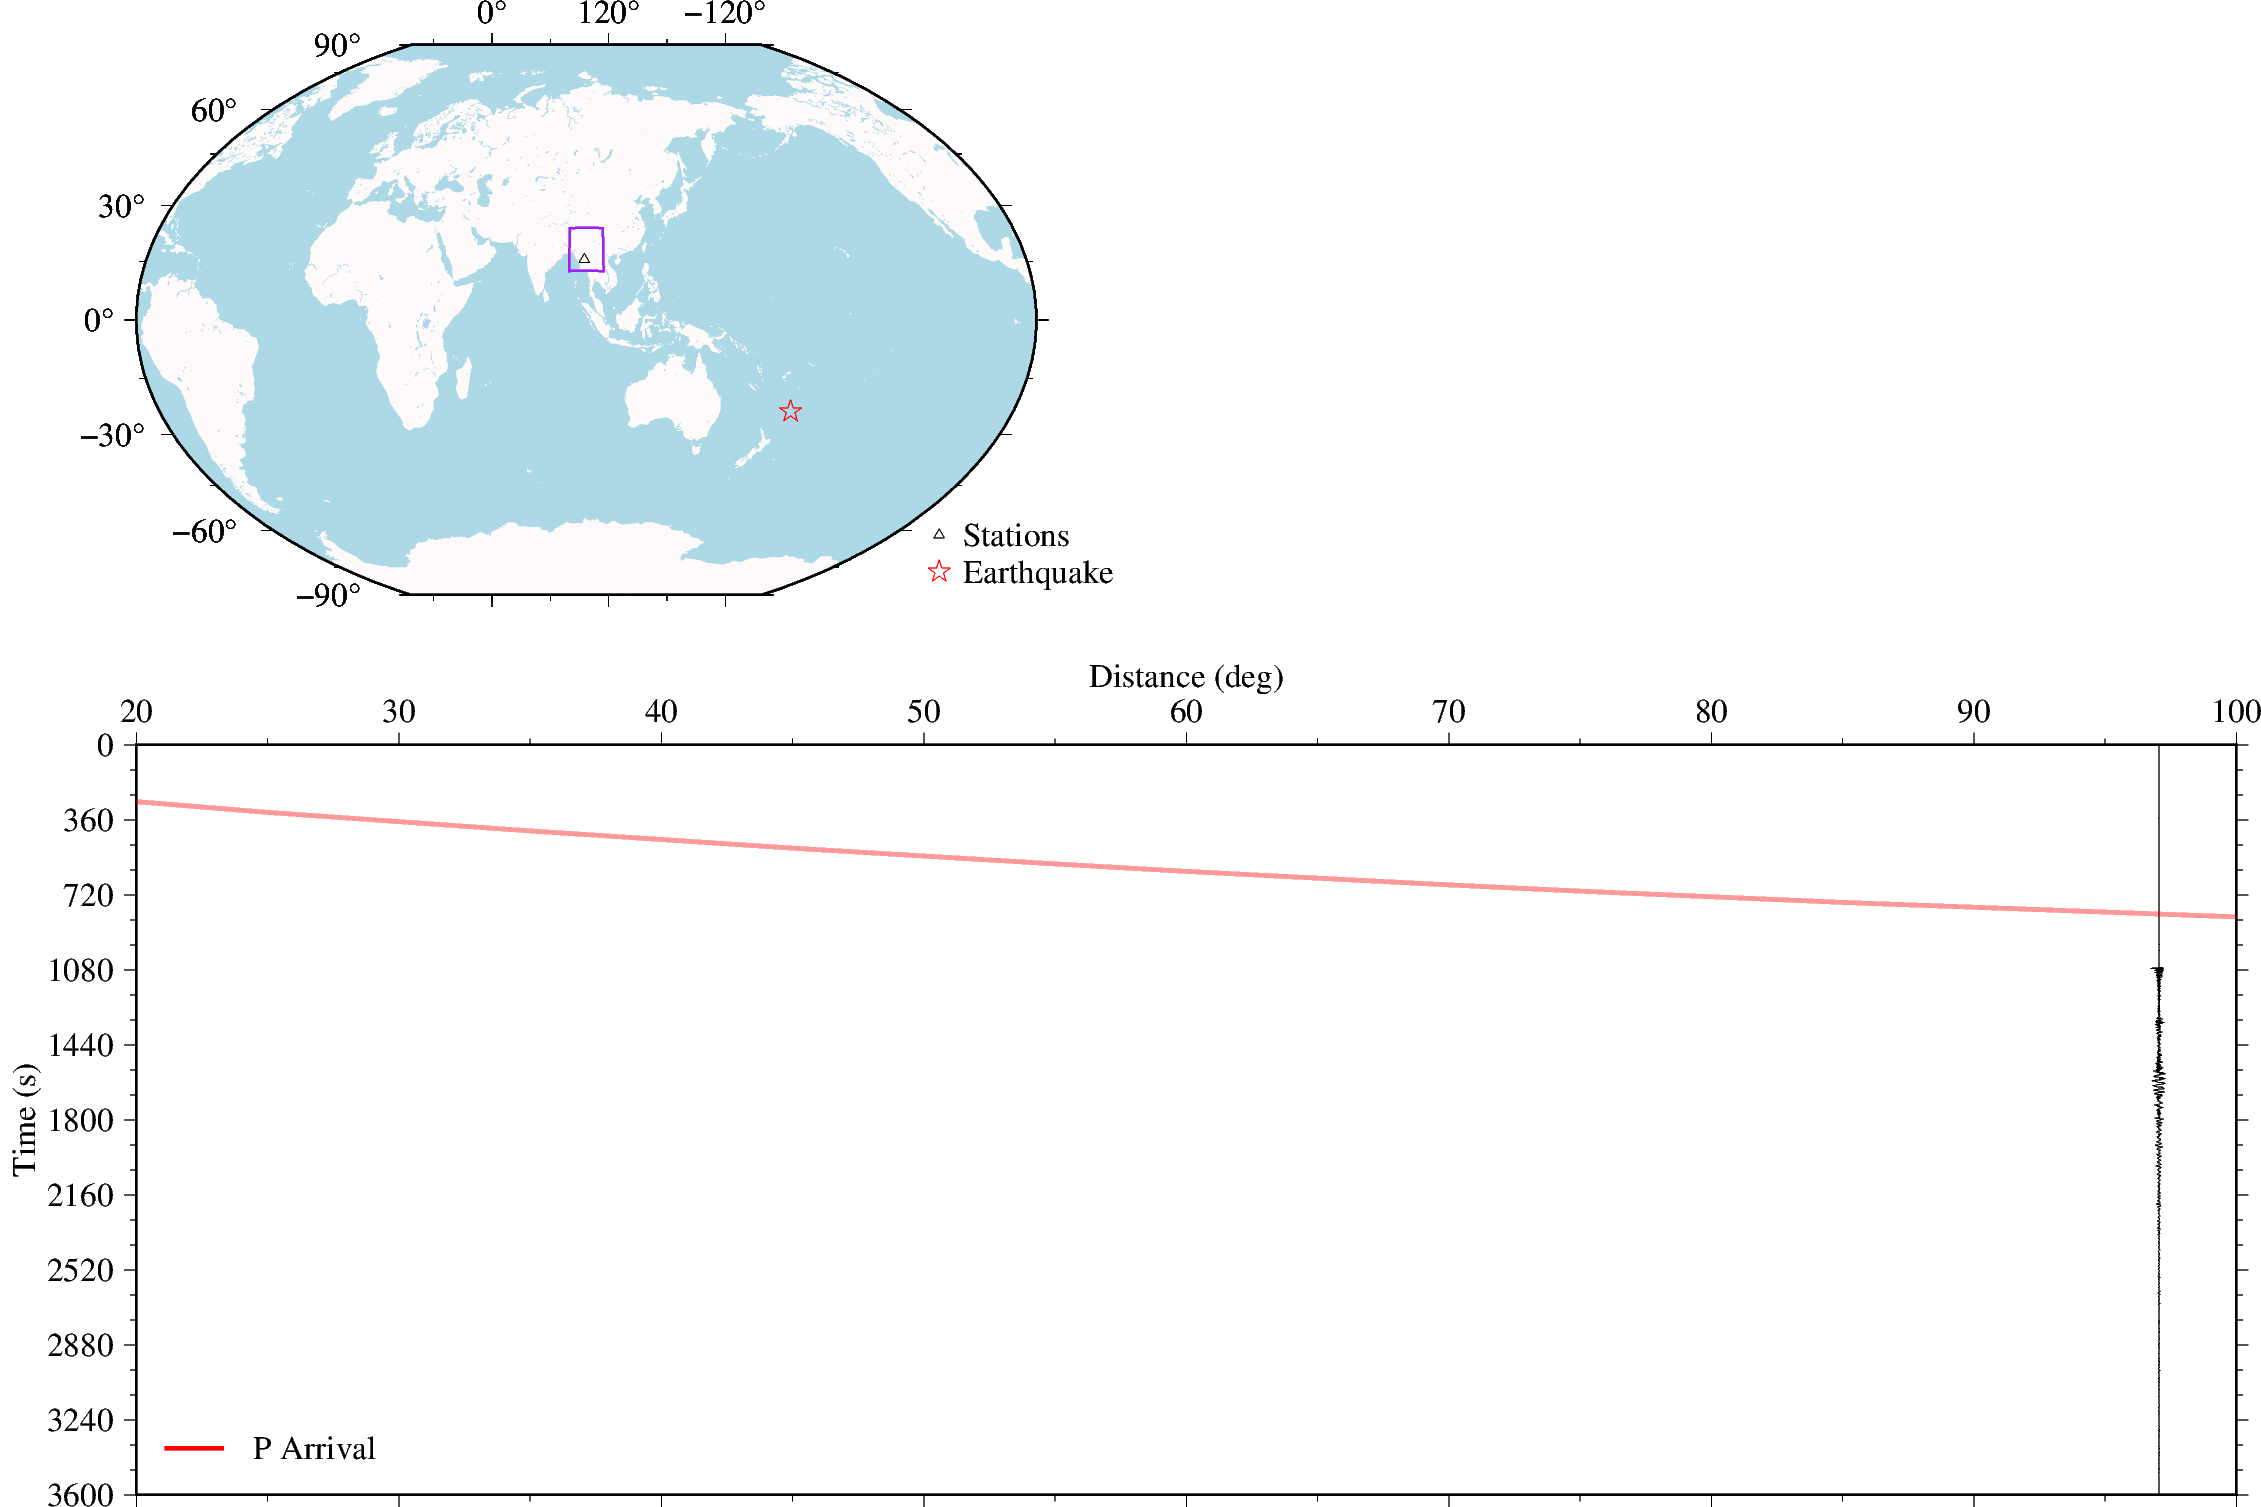

For Event: 20210305004918658


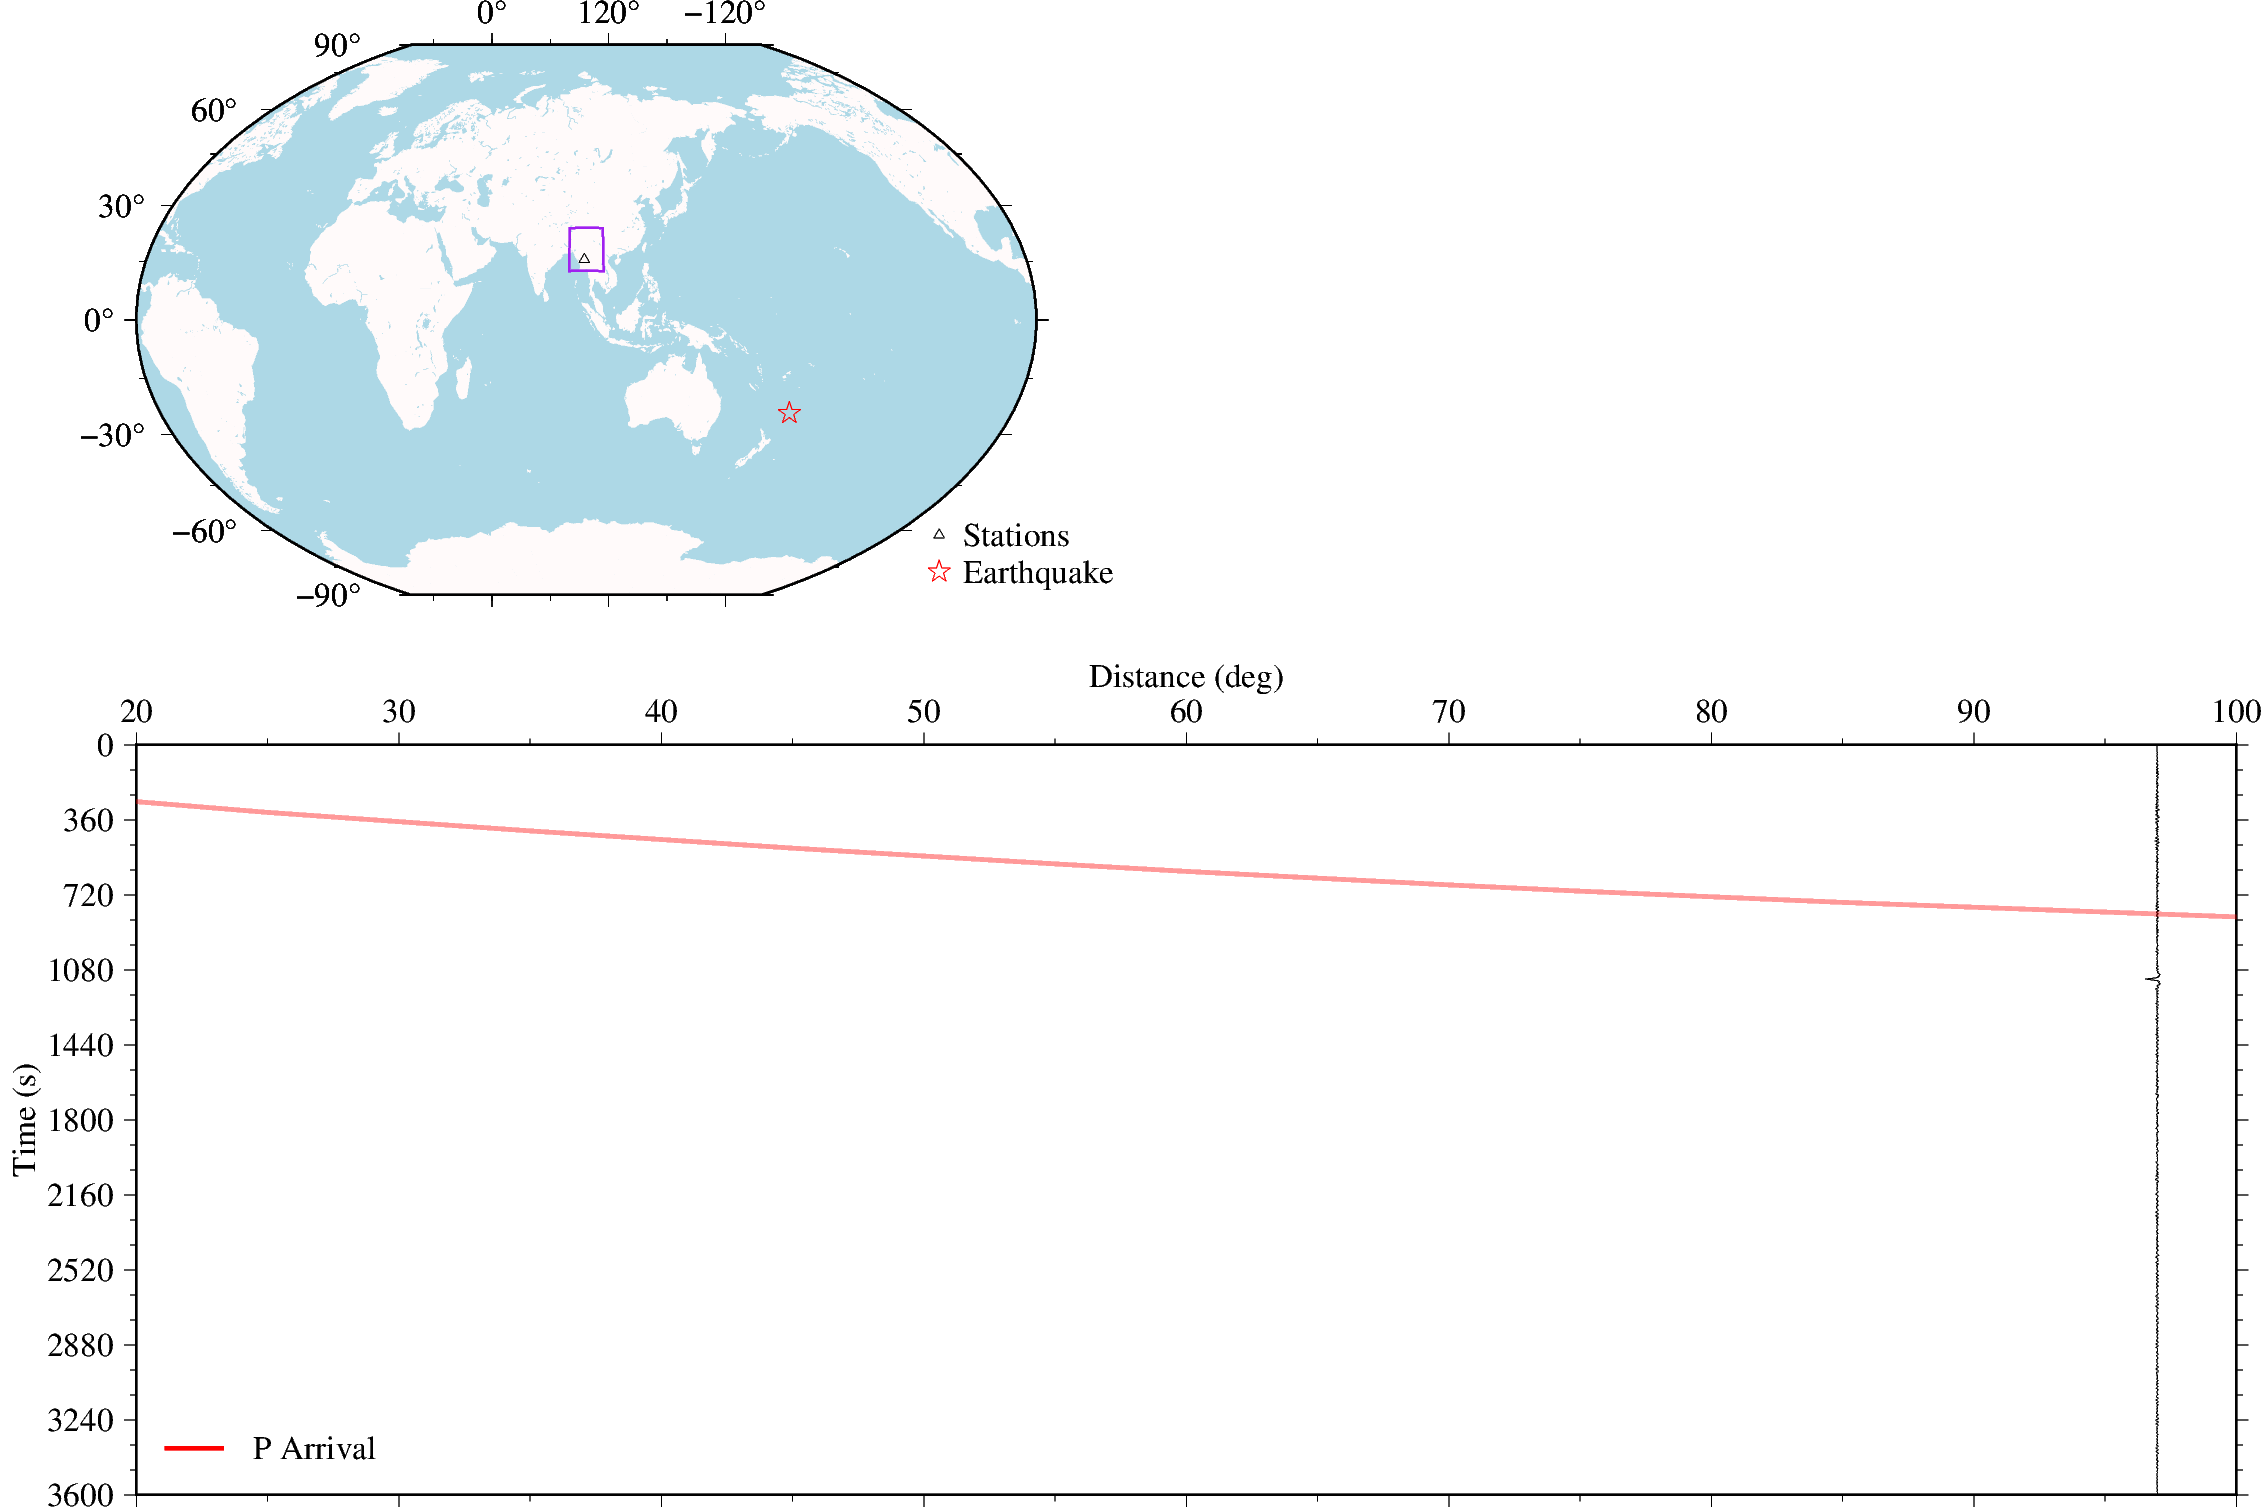

For Event: 20210519175436366
For Event: 20210927054036822


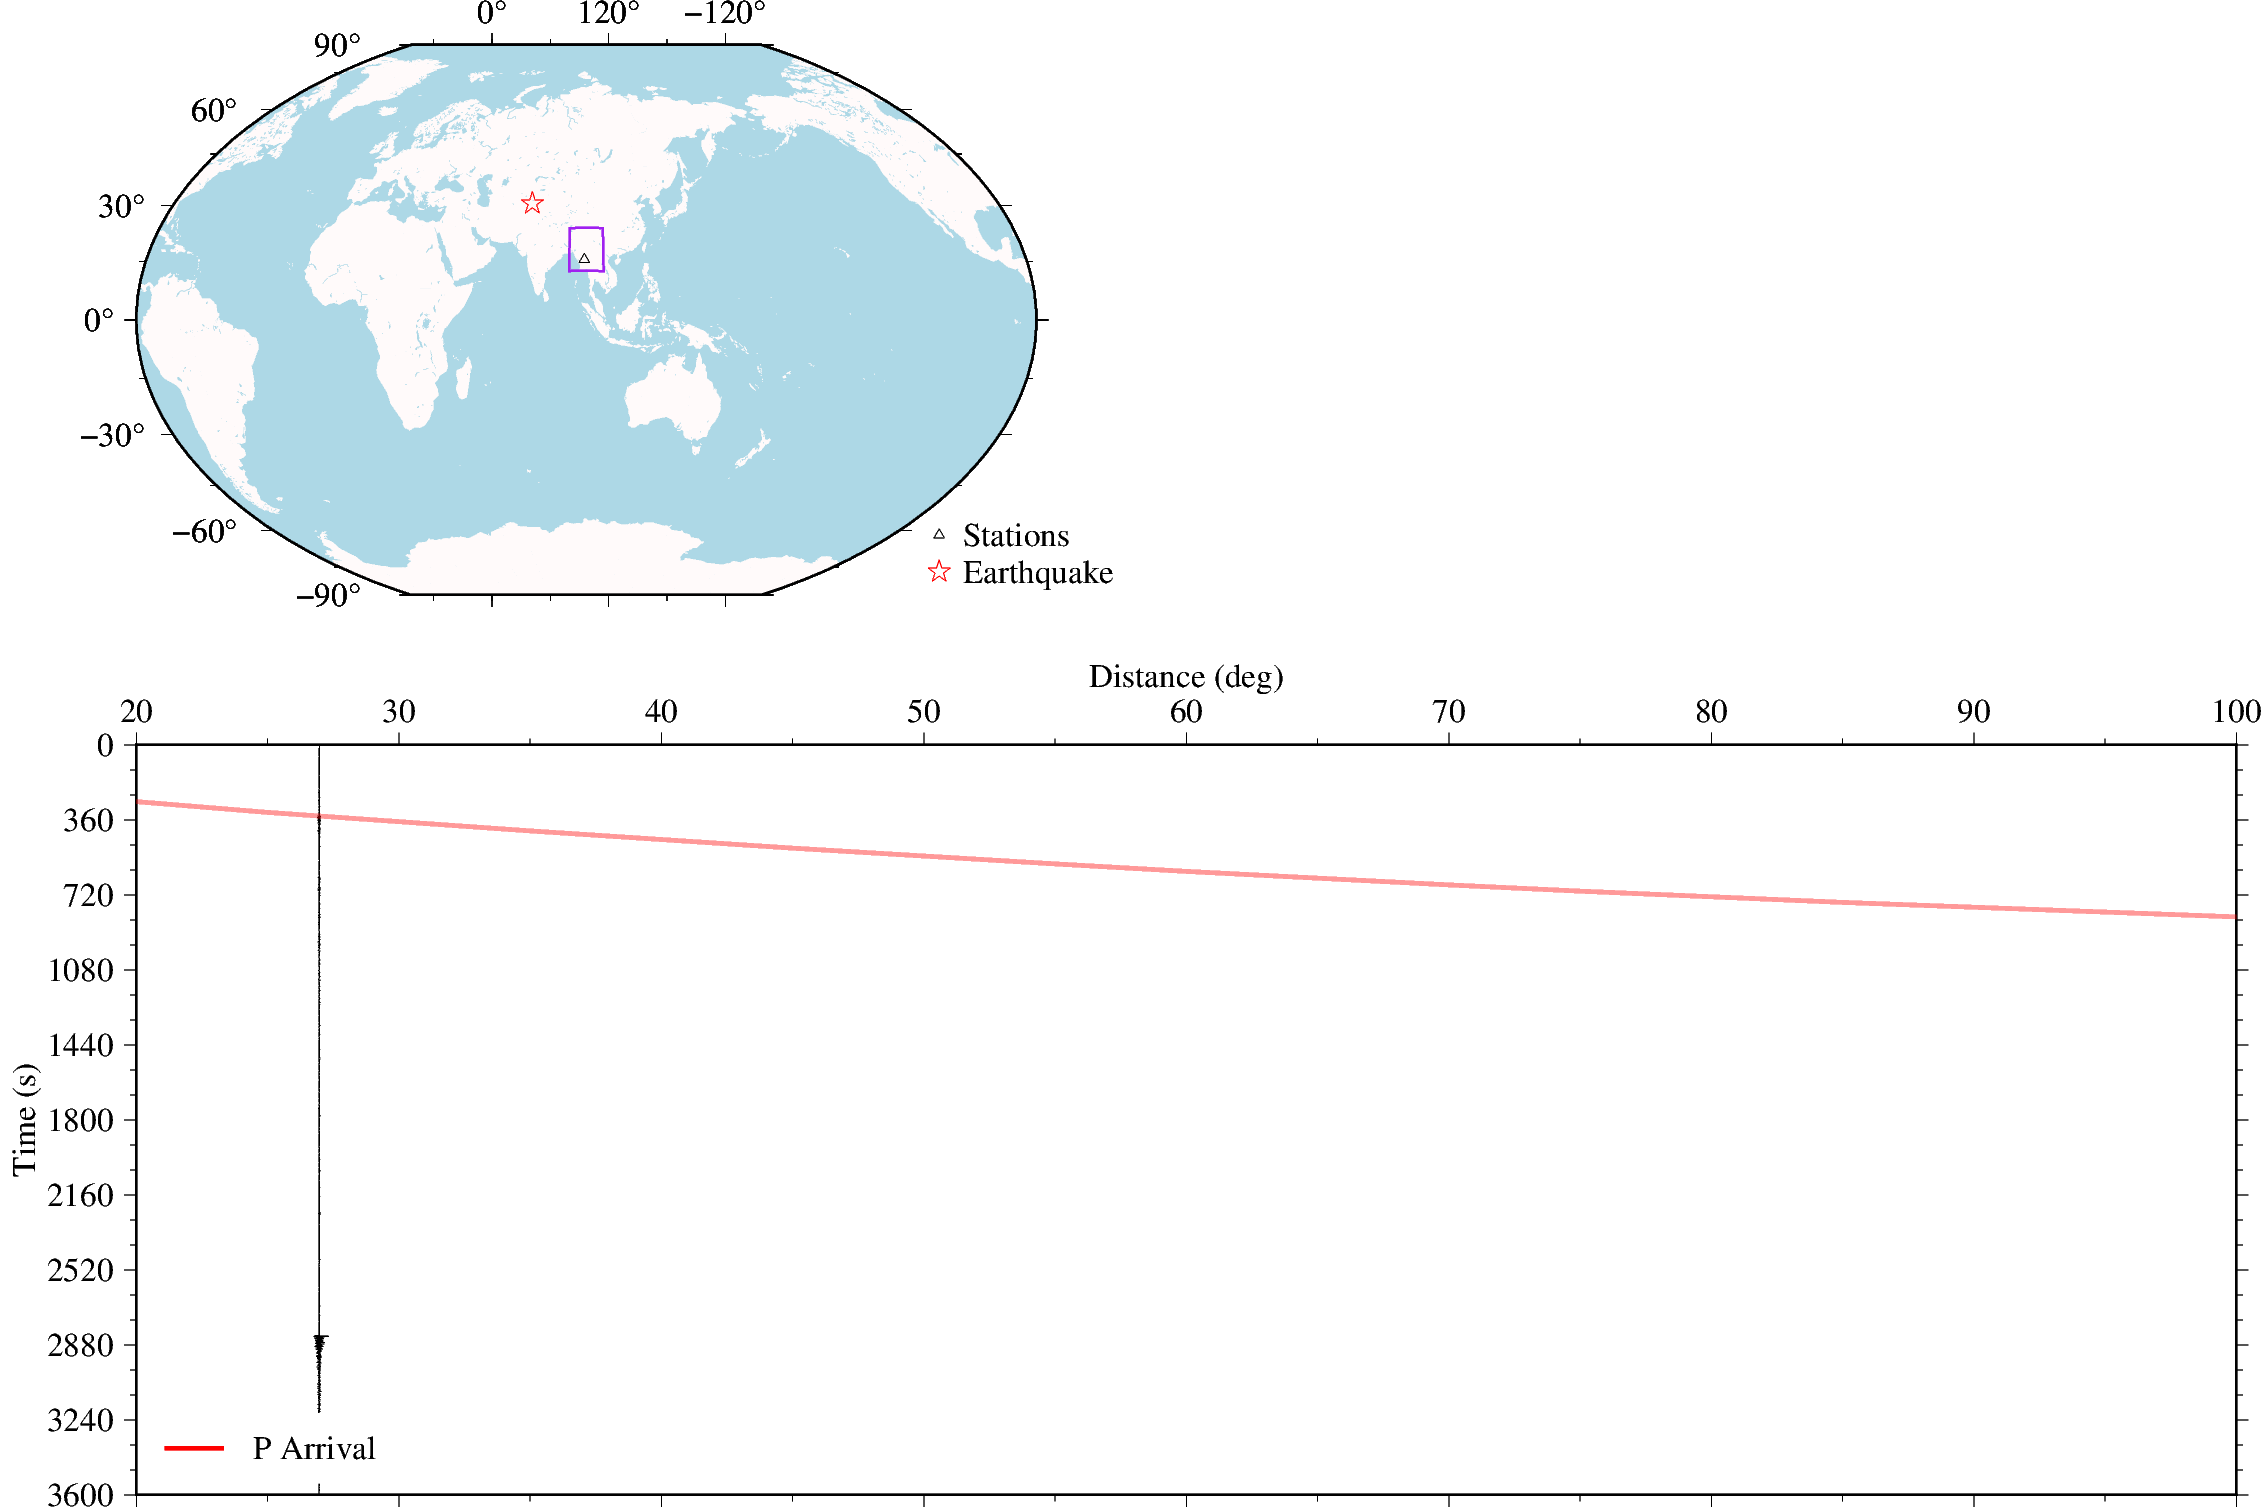

For Event: 20210806005937648
For Event: 20210307070409967


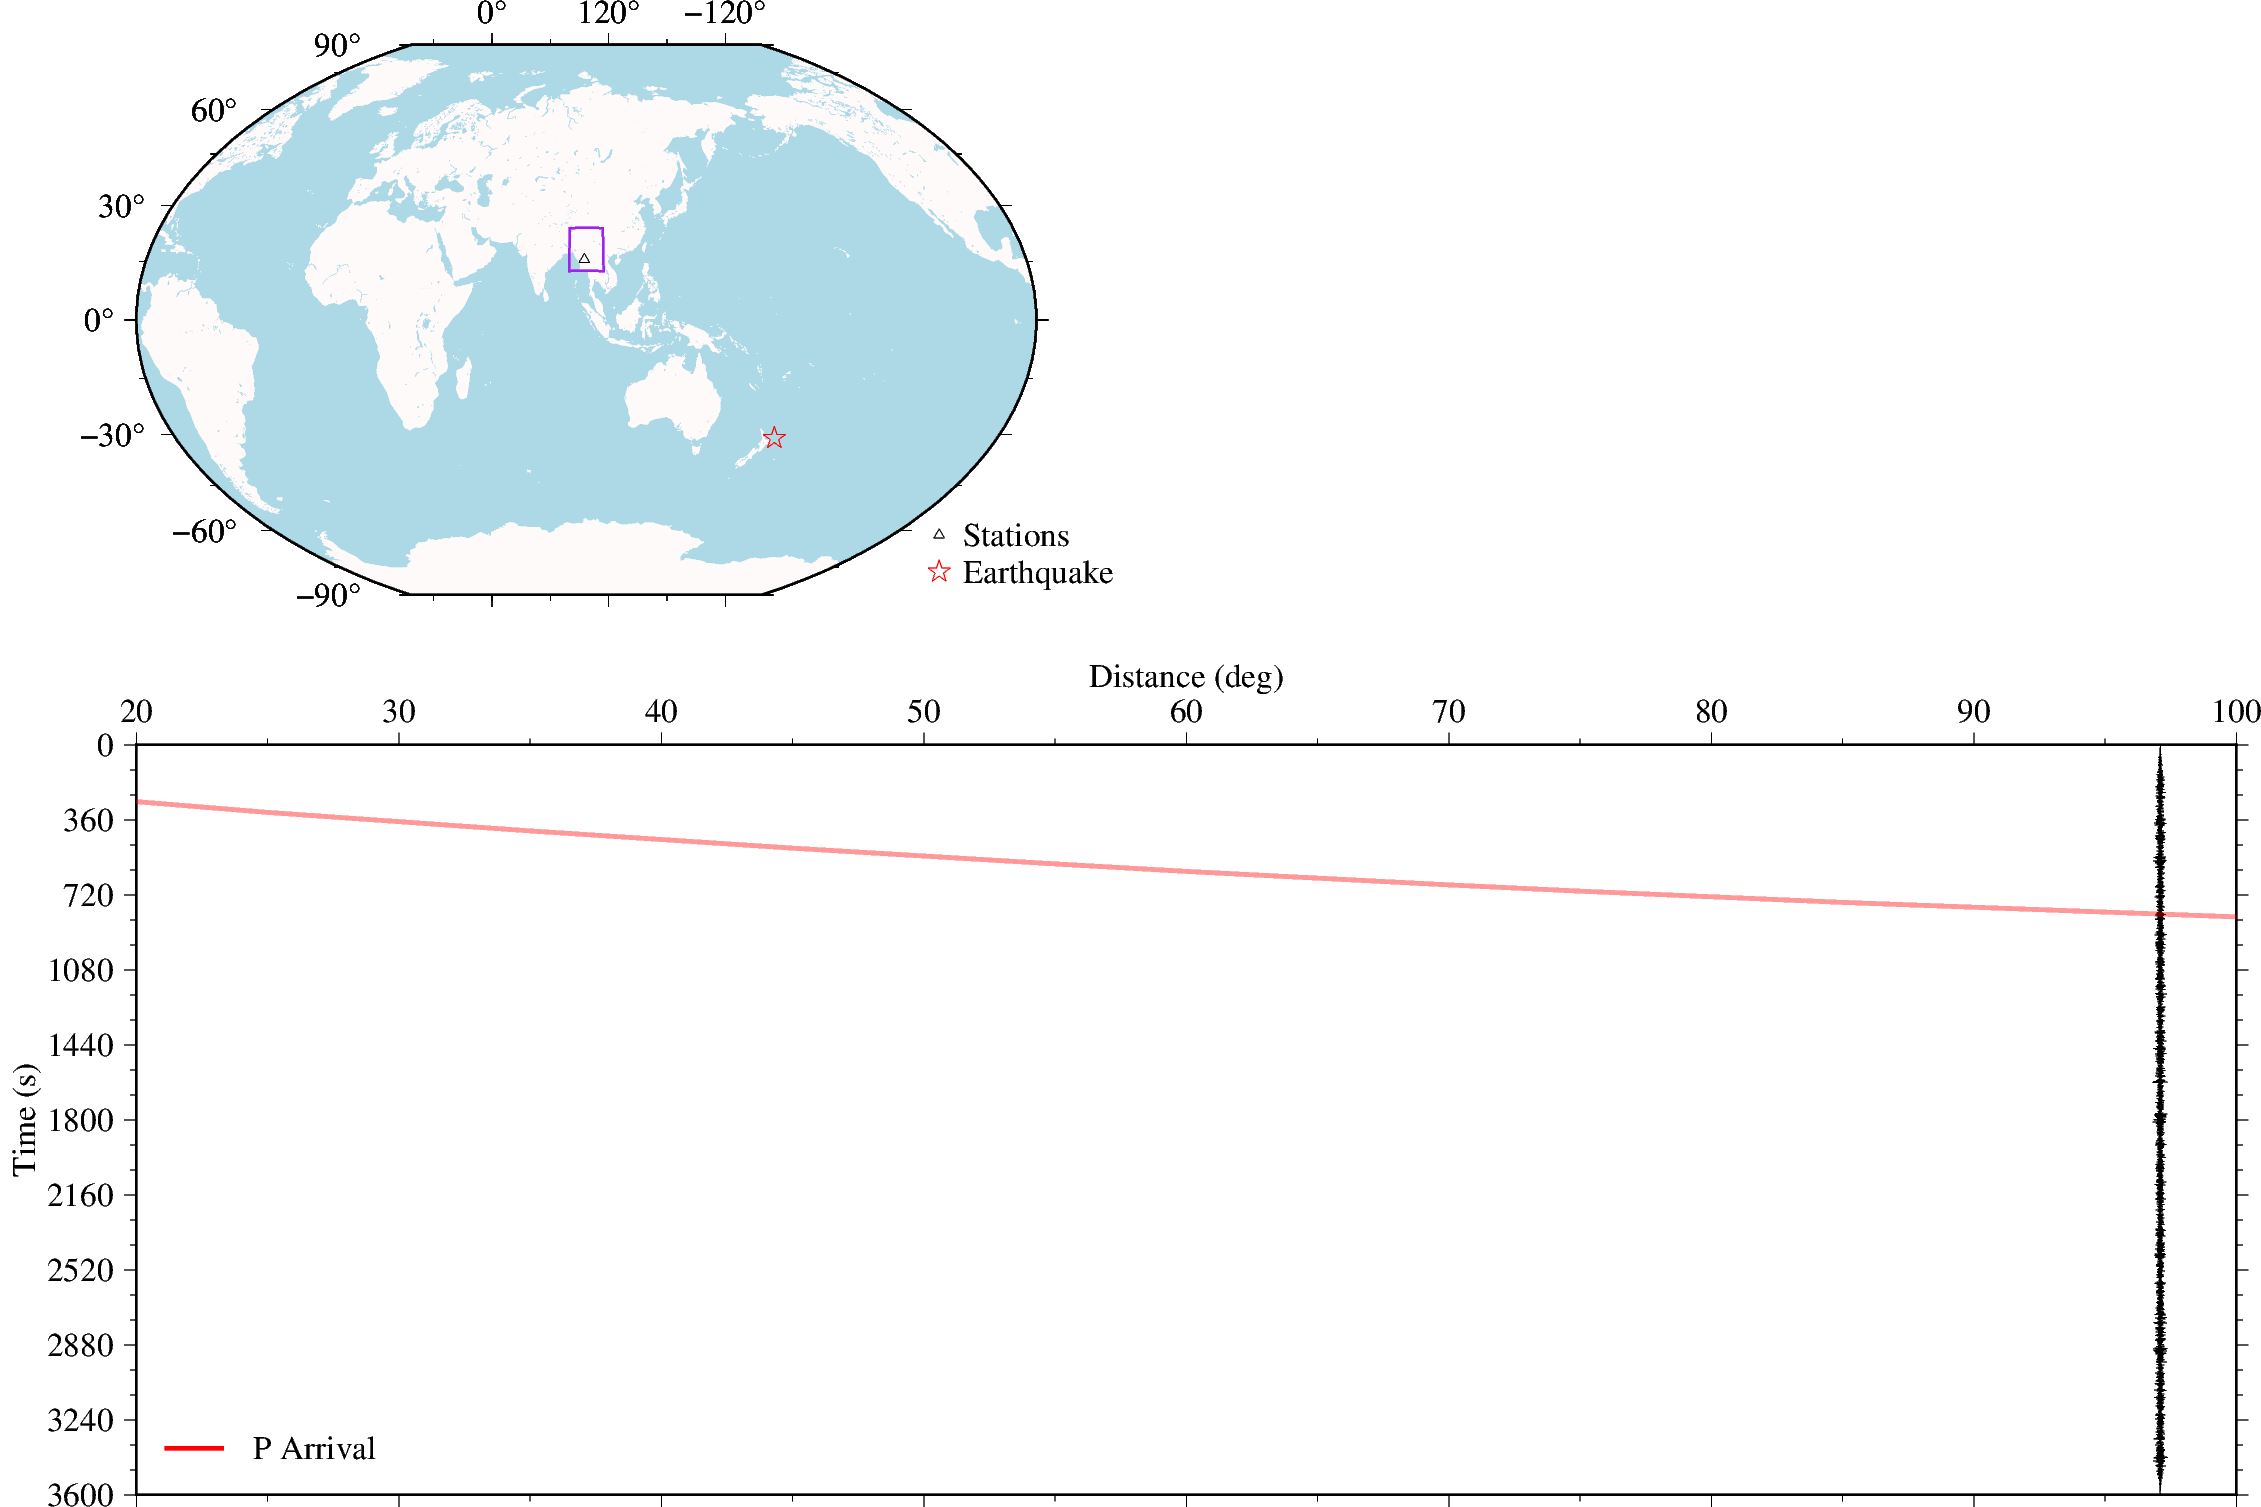

For Event: 20210426210727653
For Event: 20210305024312943


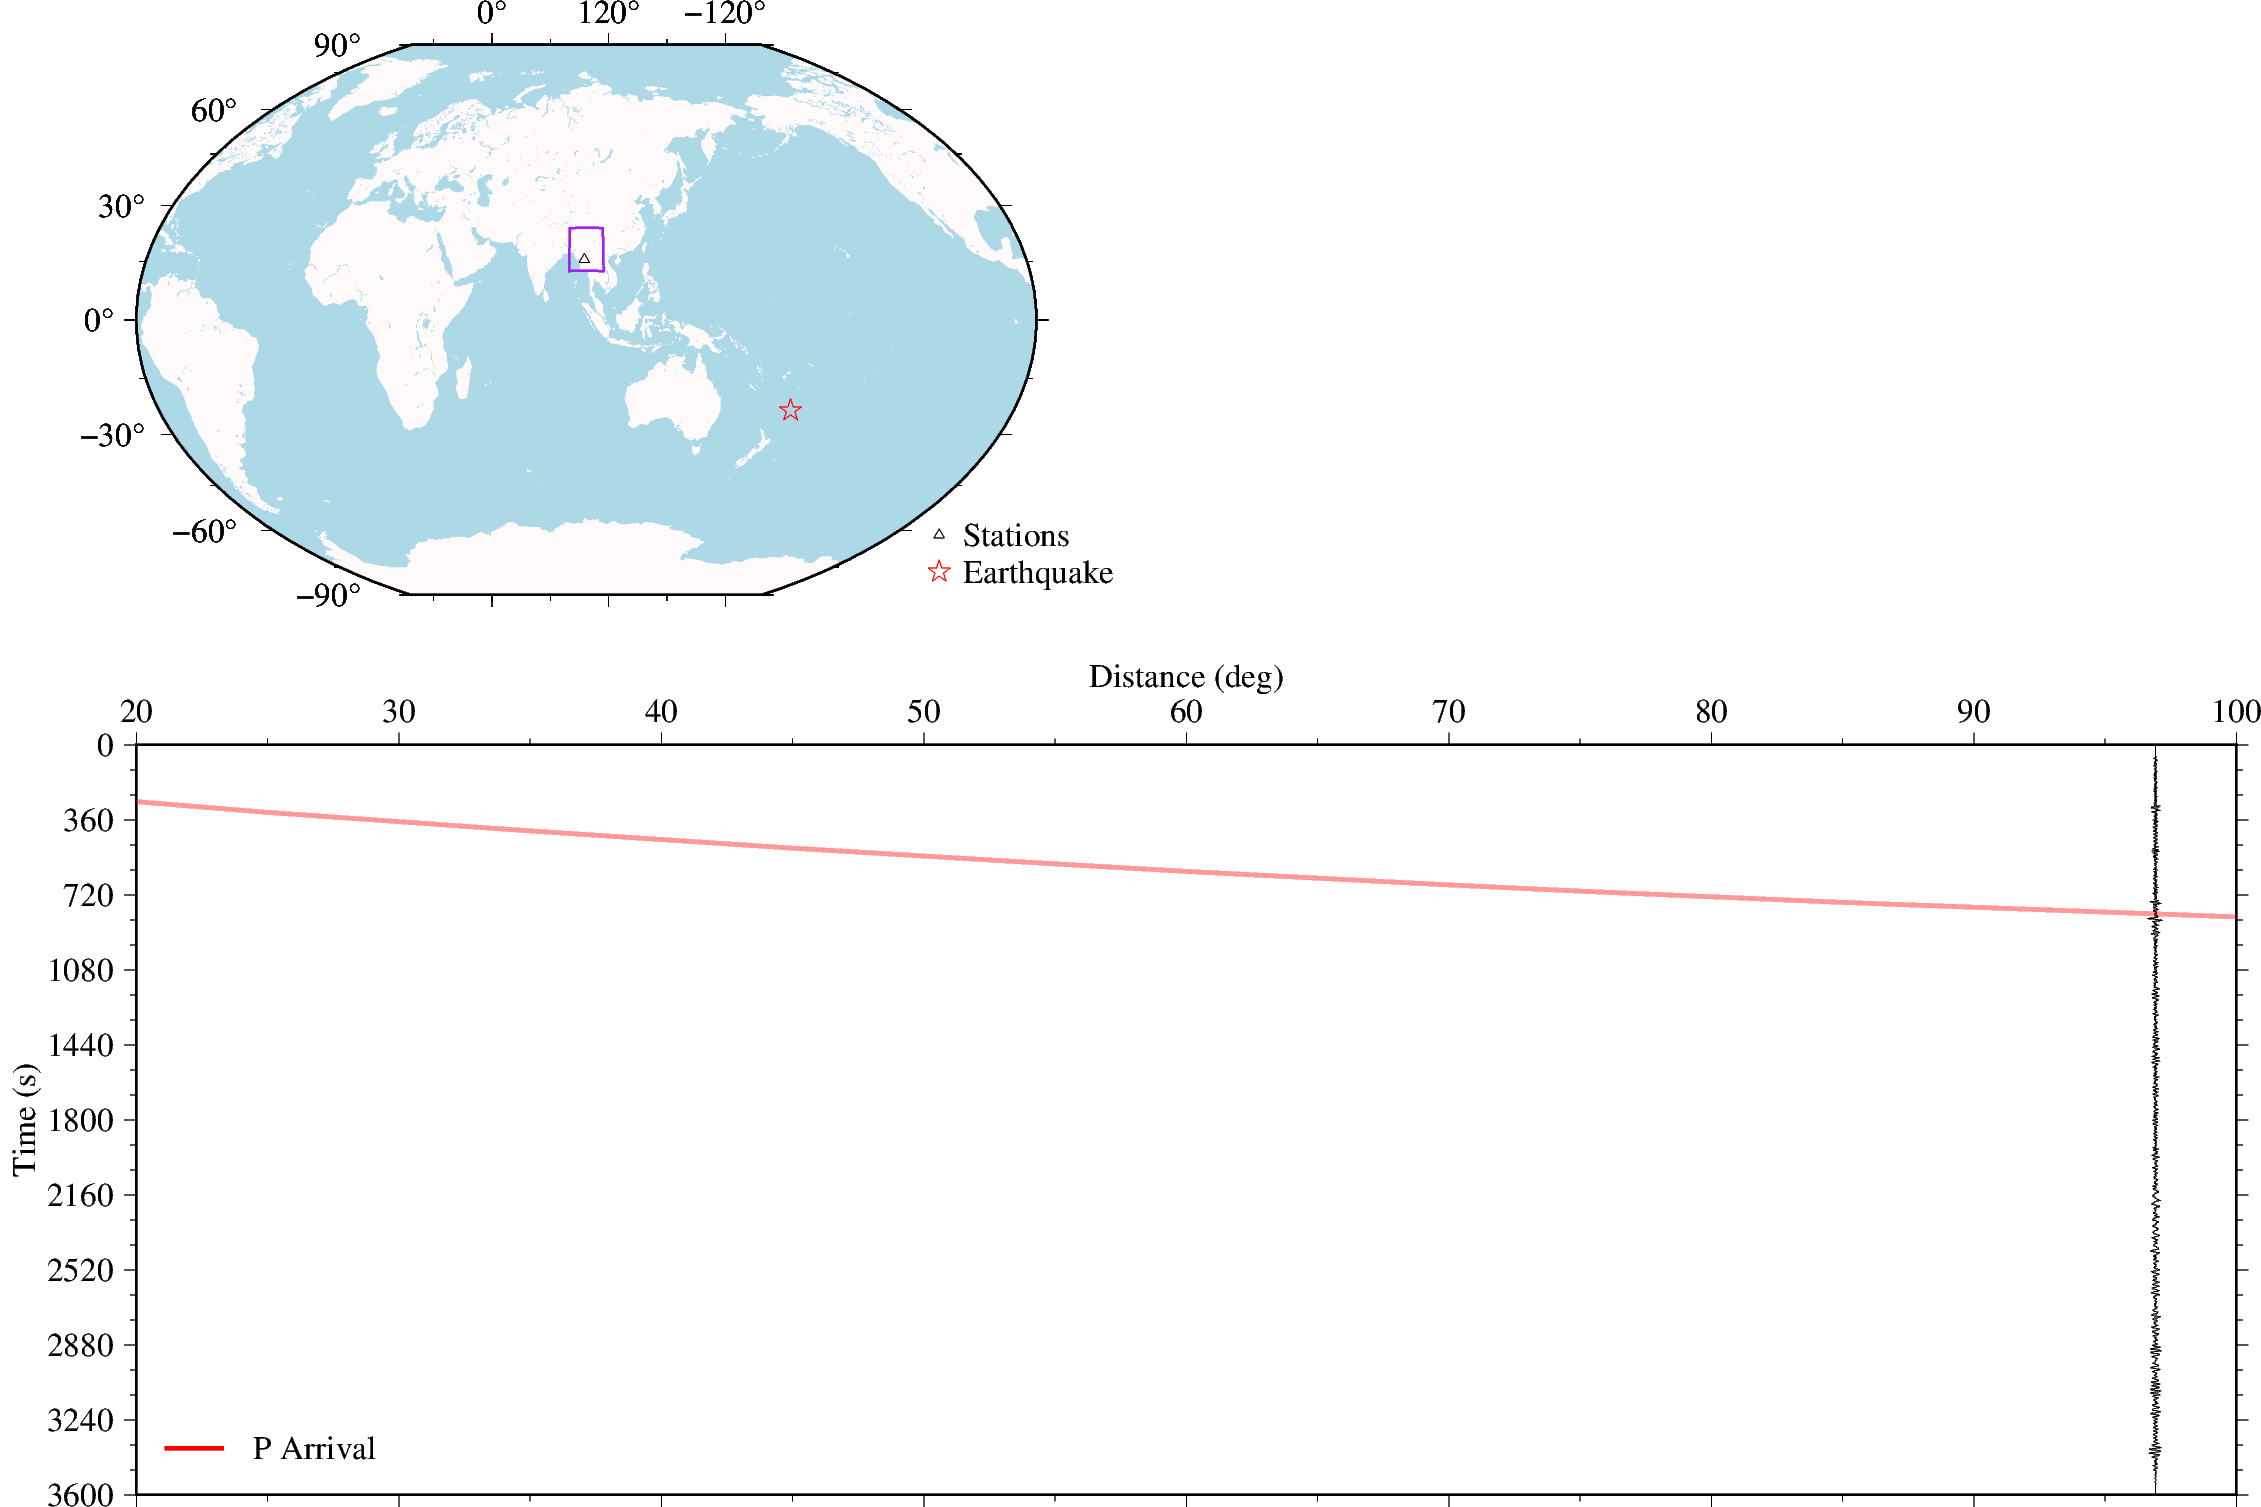

For Event: 20210307105525319


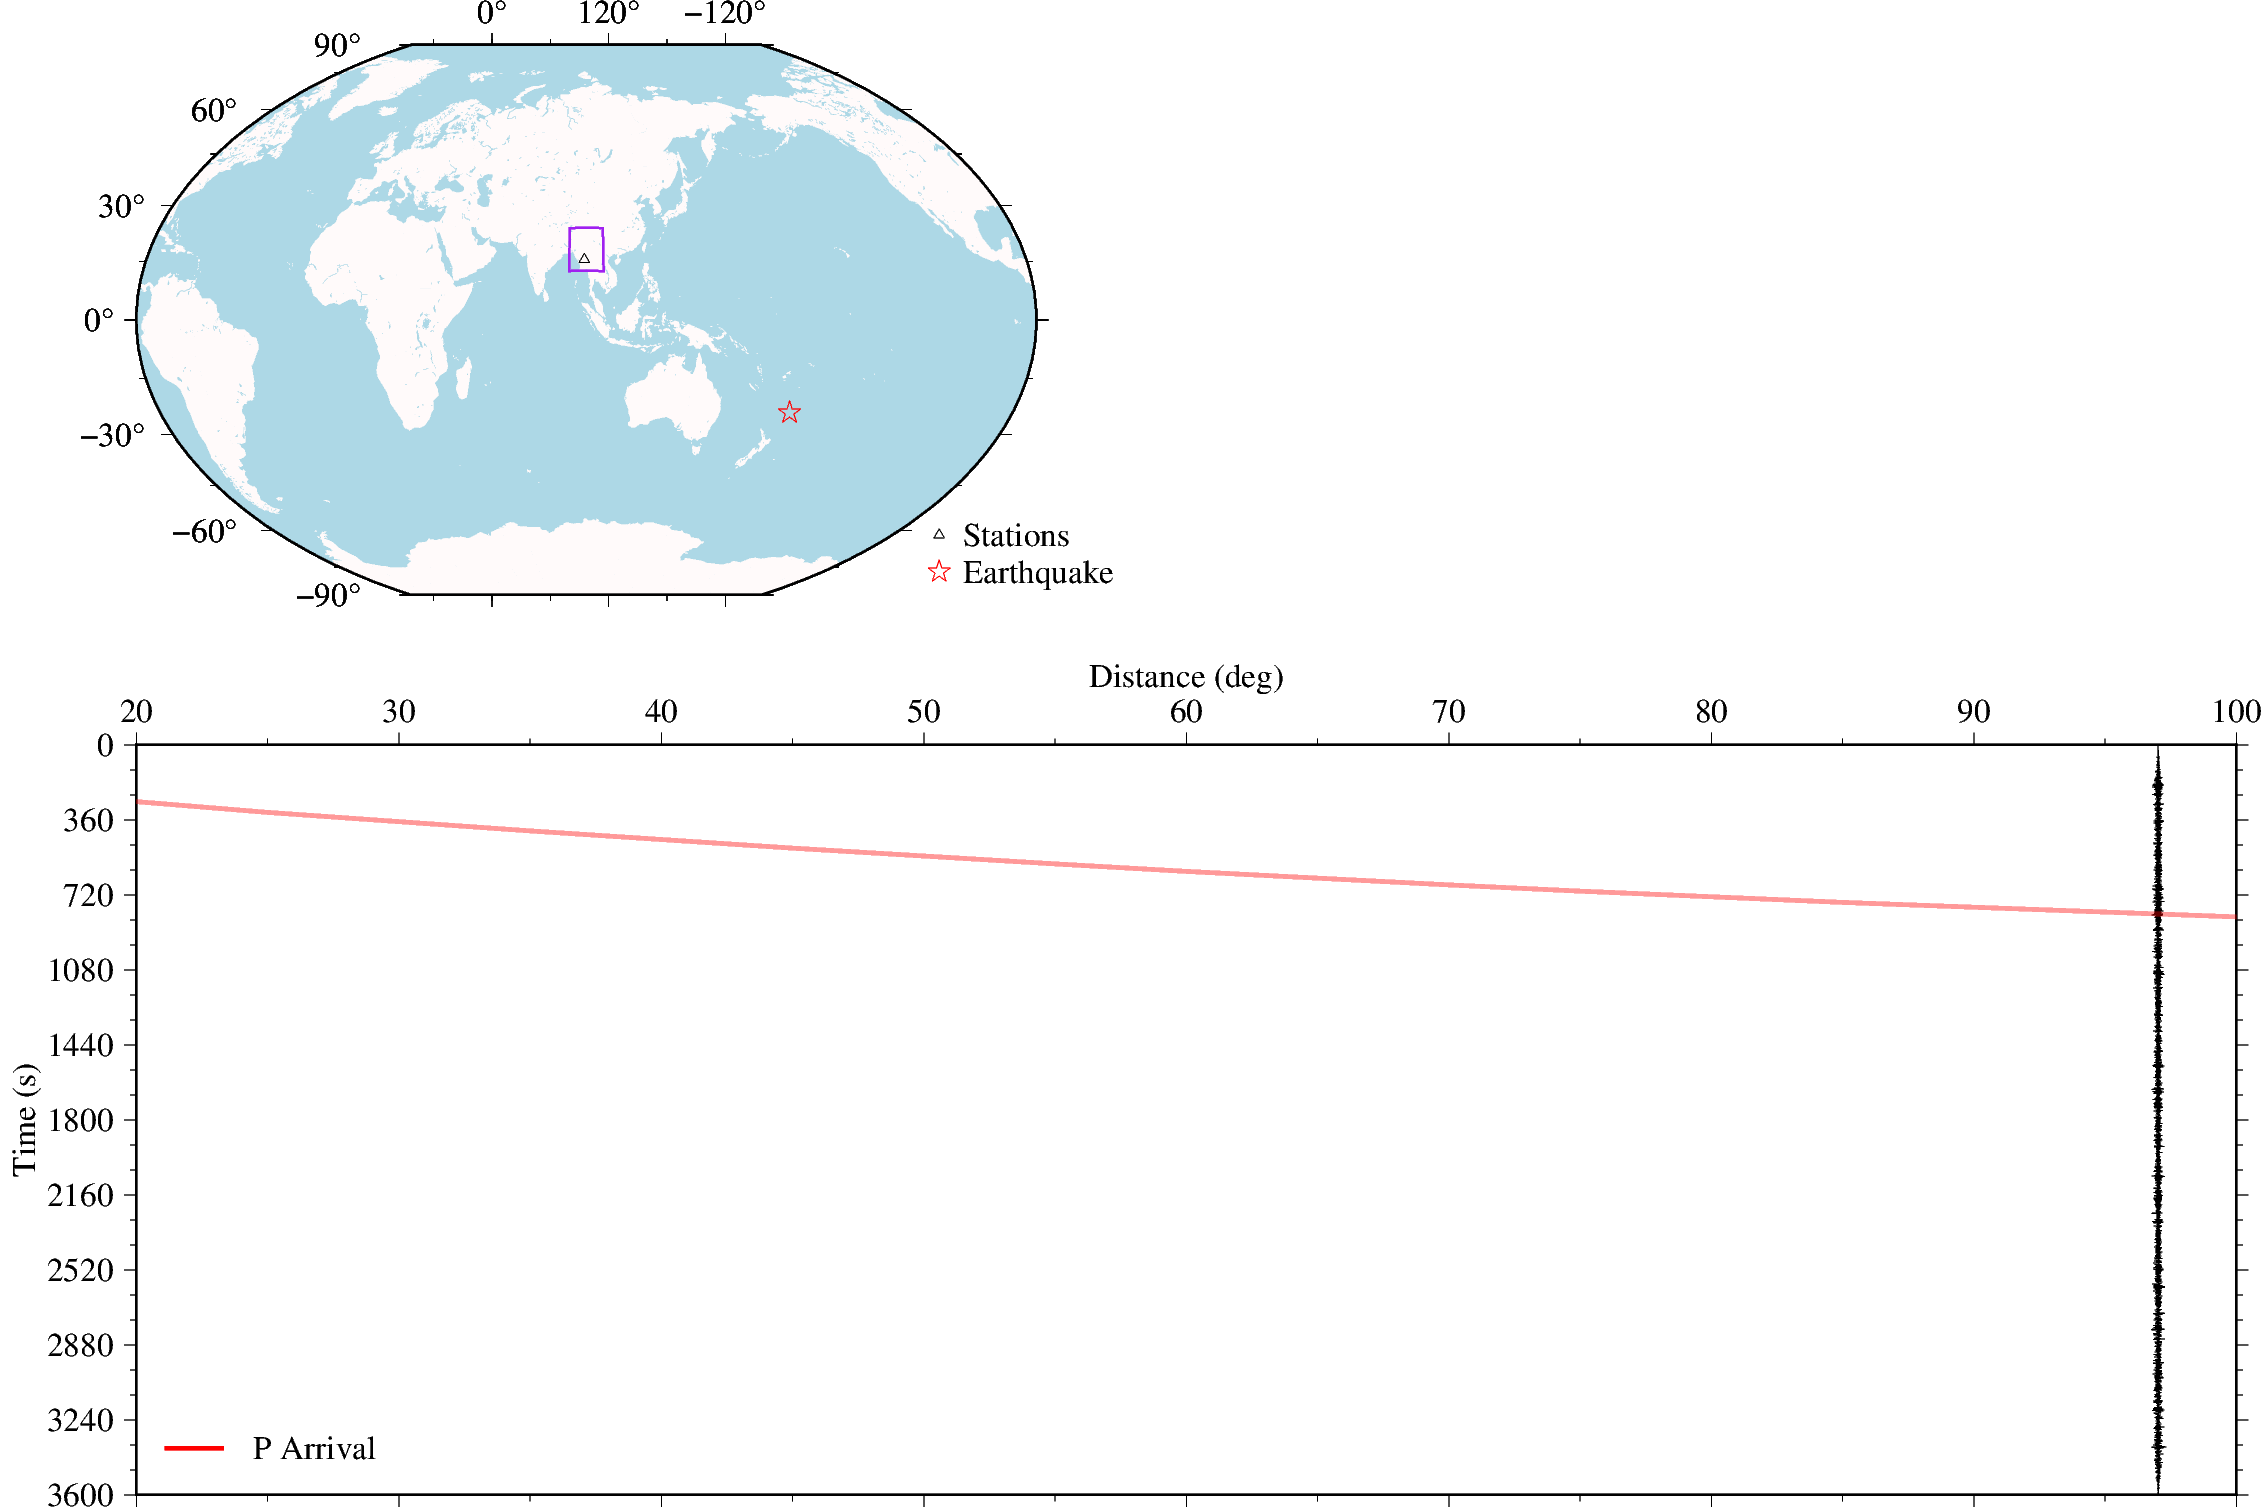

For Event: 20210605225738235
For Event: 20210212110538395


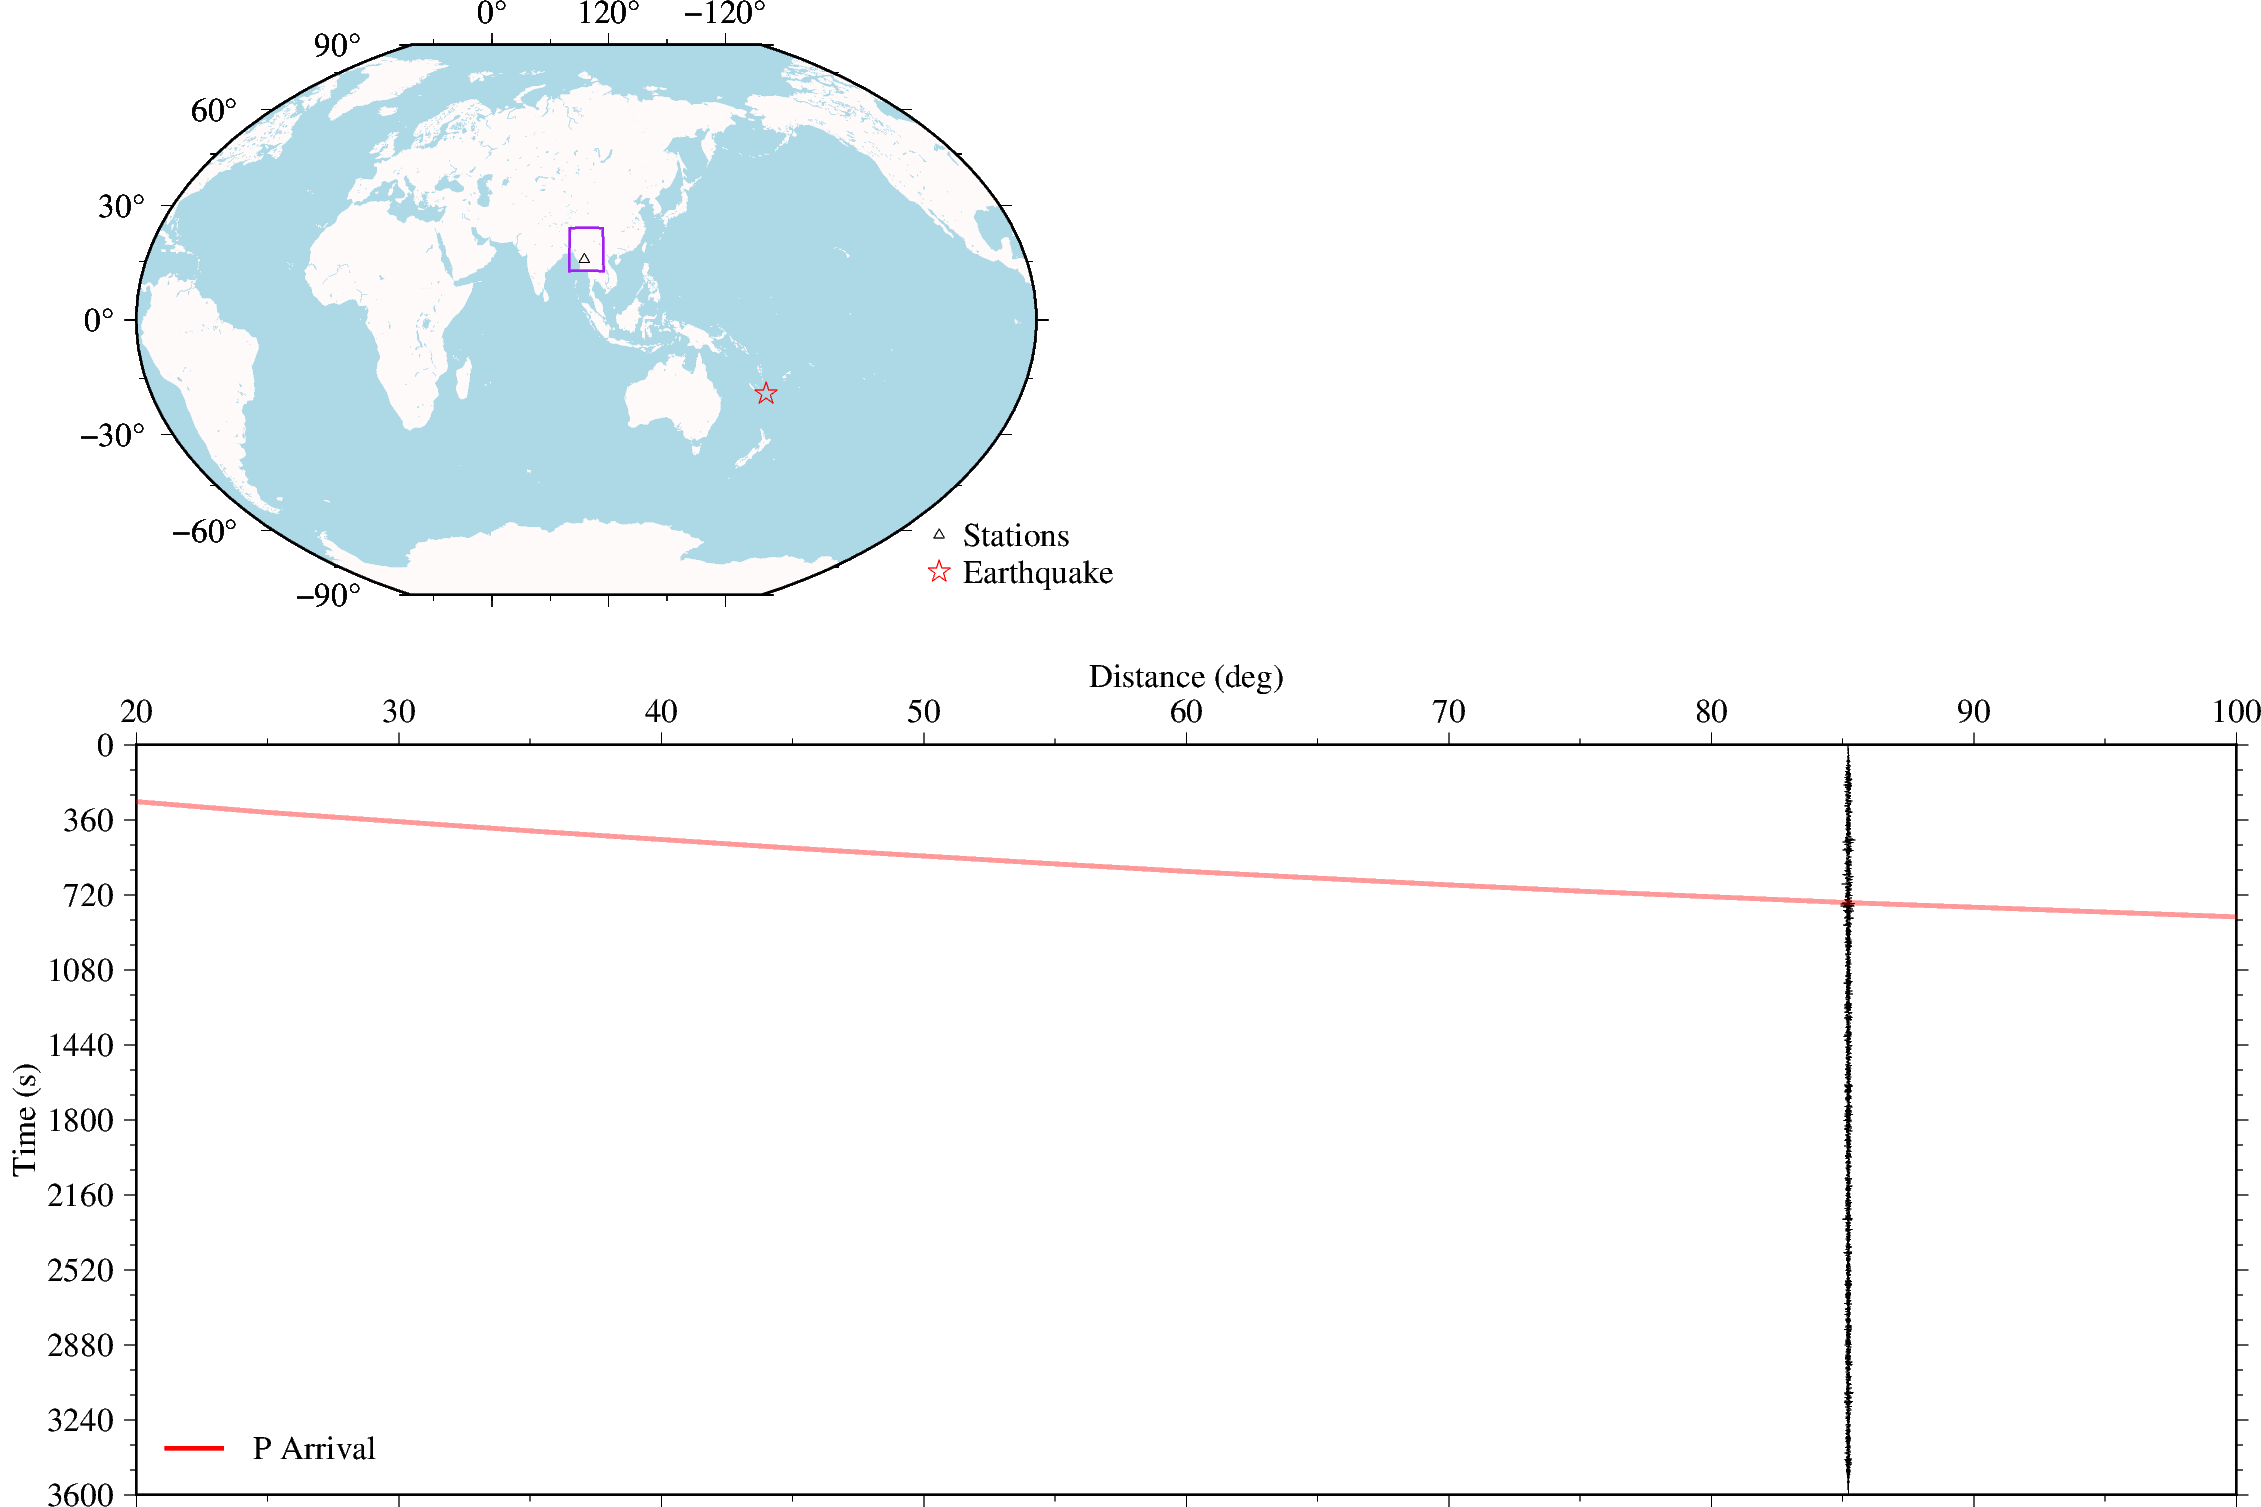

For Event: 20210305211009484
For Event: 20211221224215051


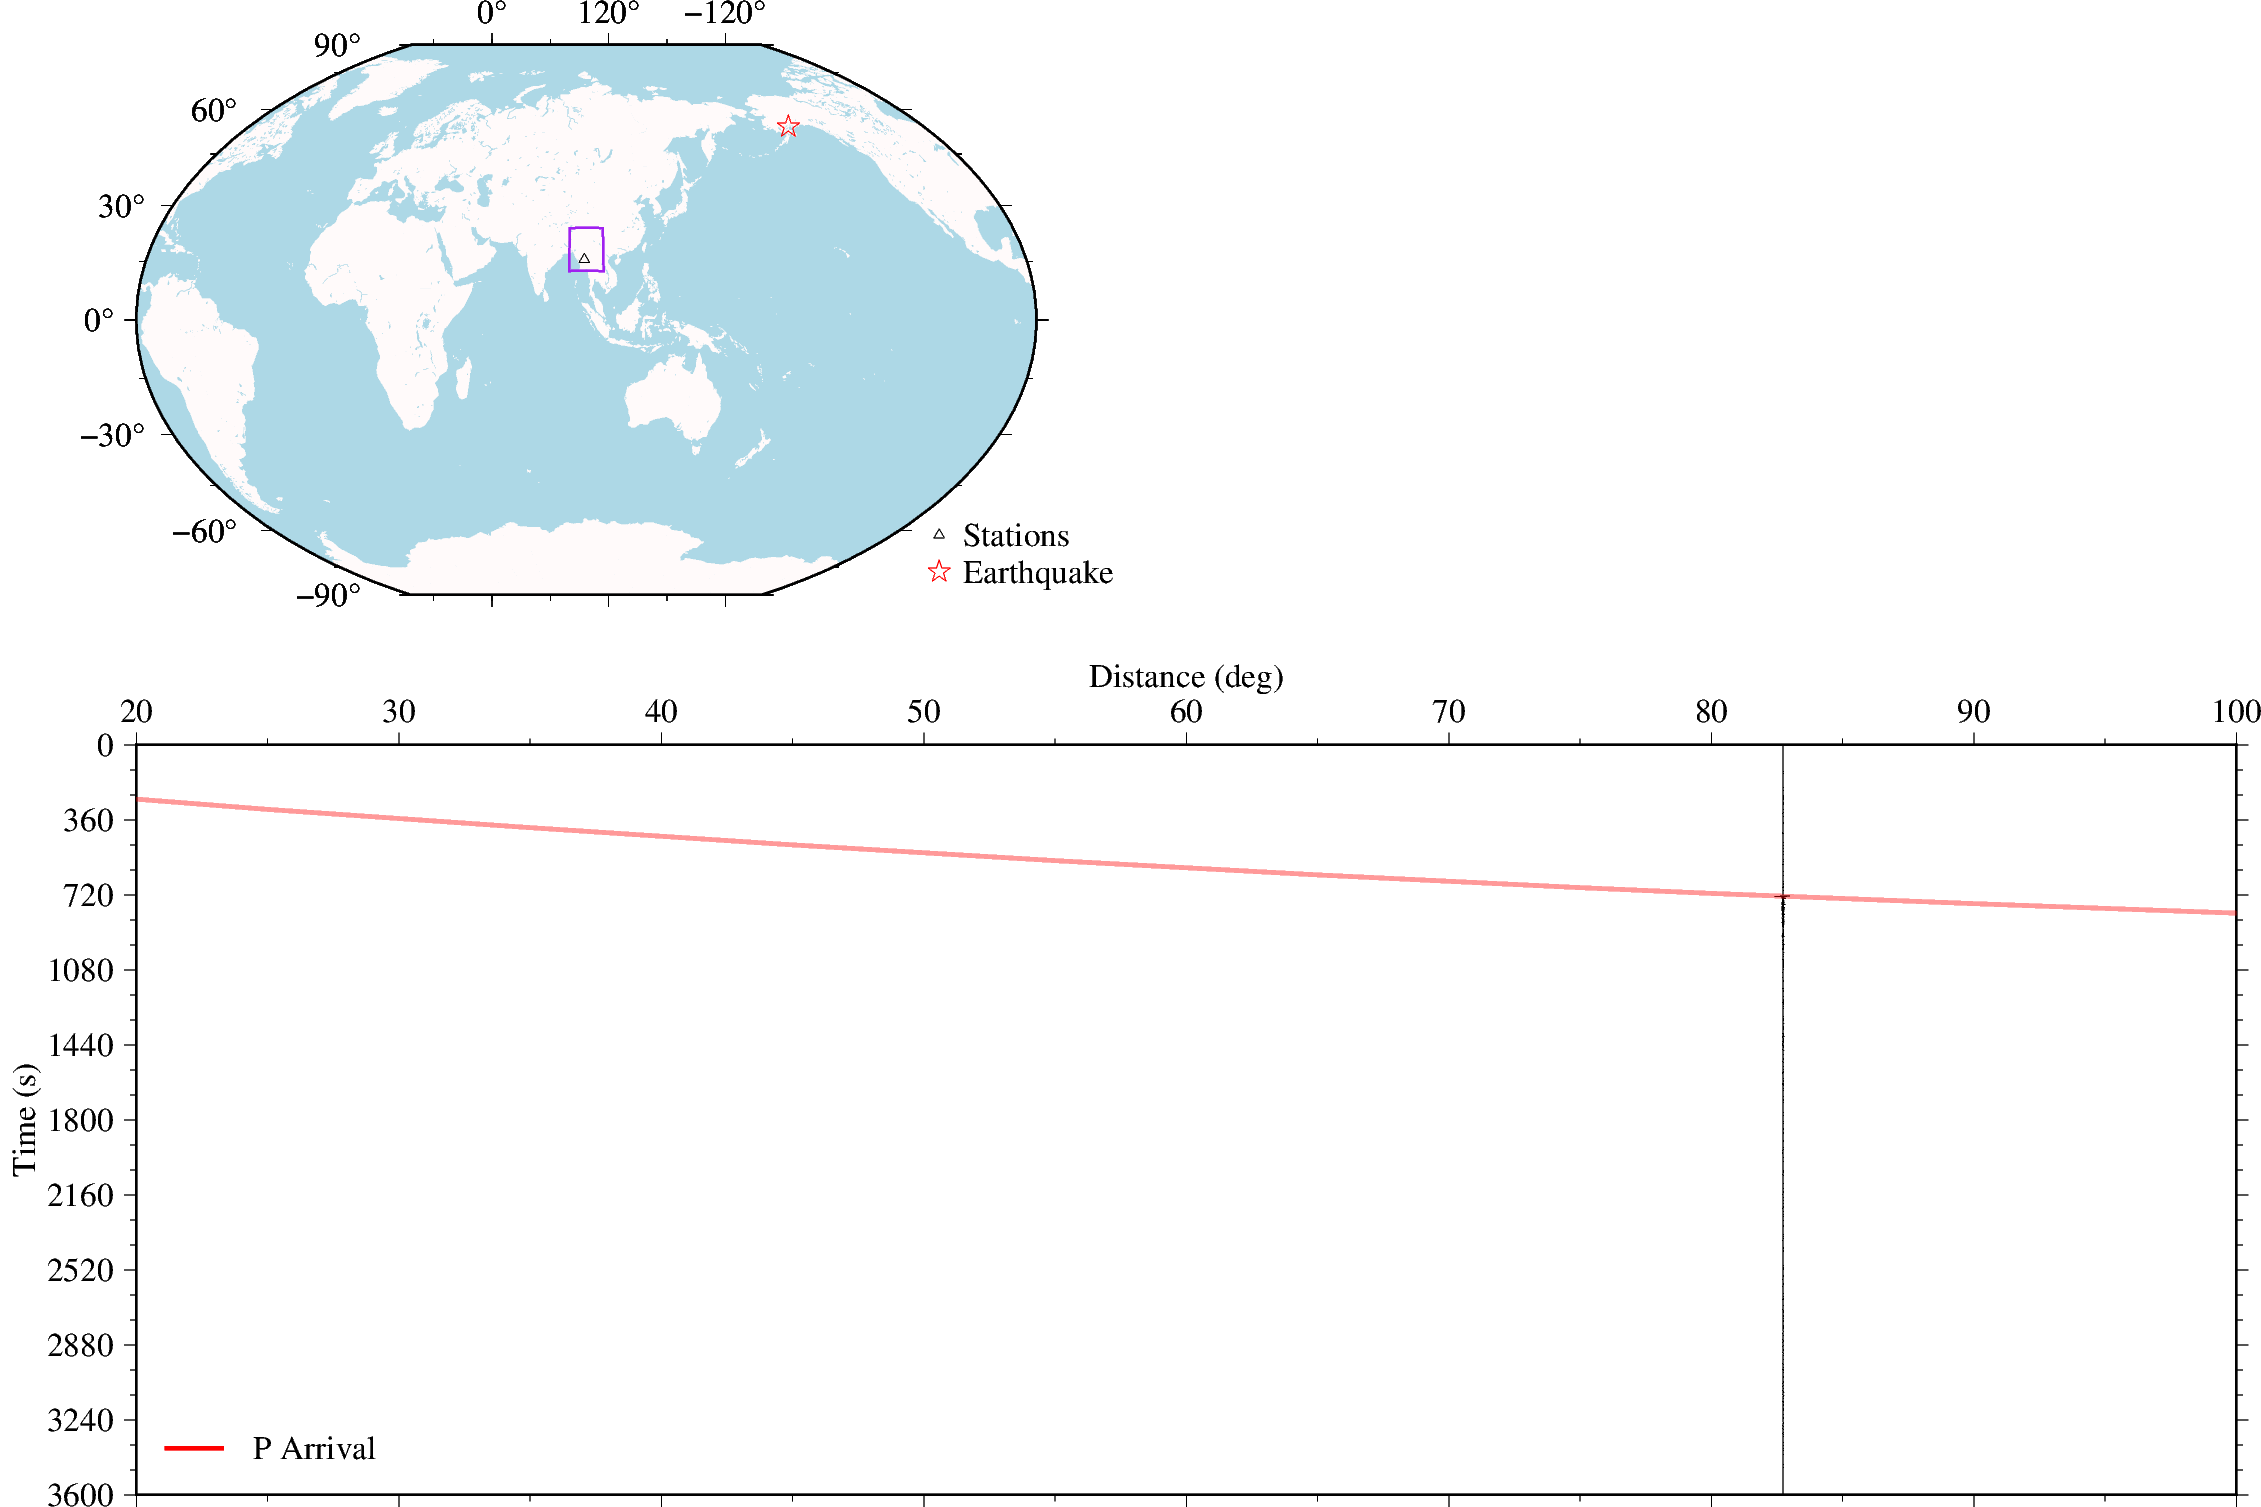

For Event: 20210306120523693


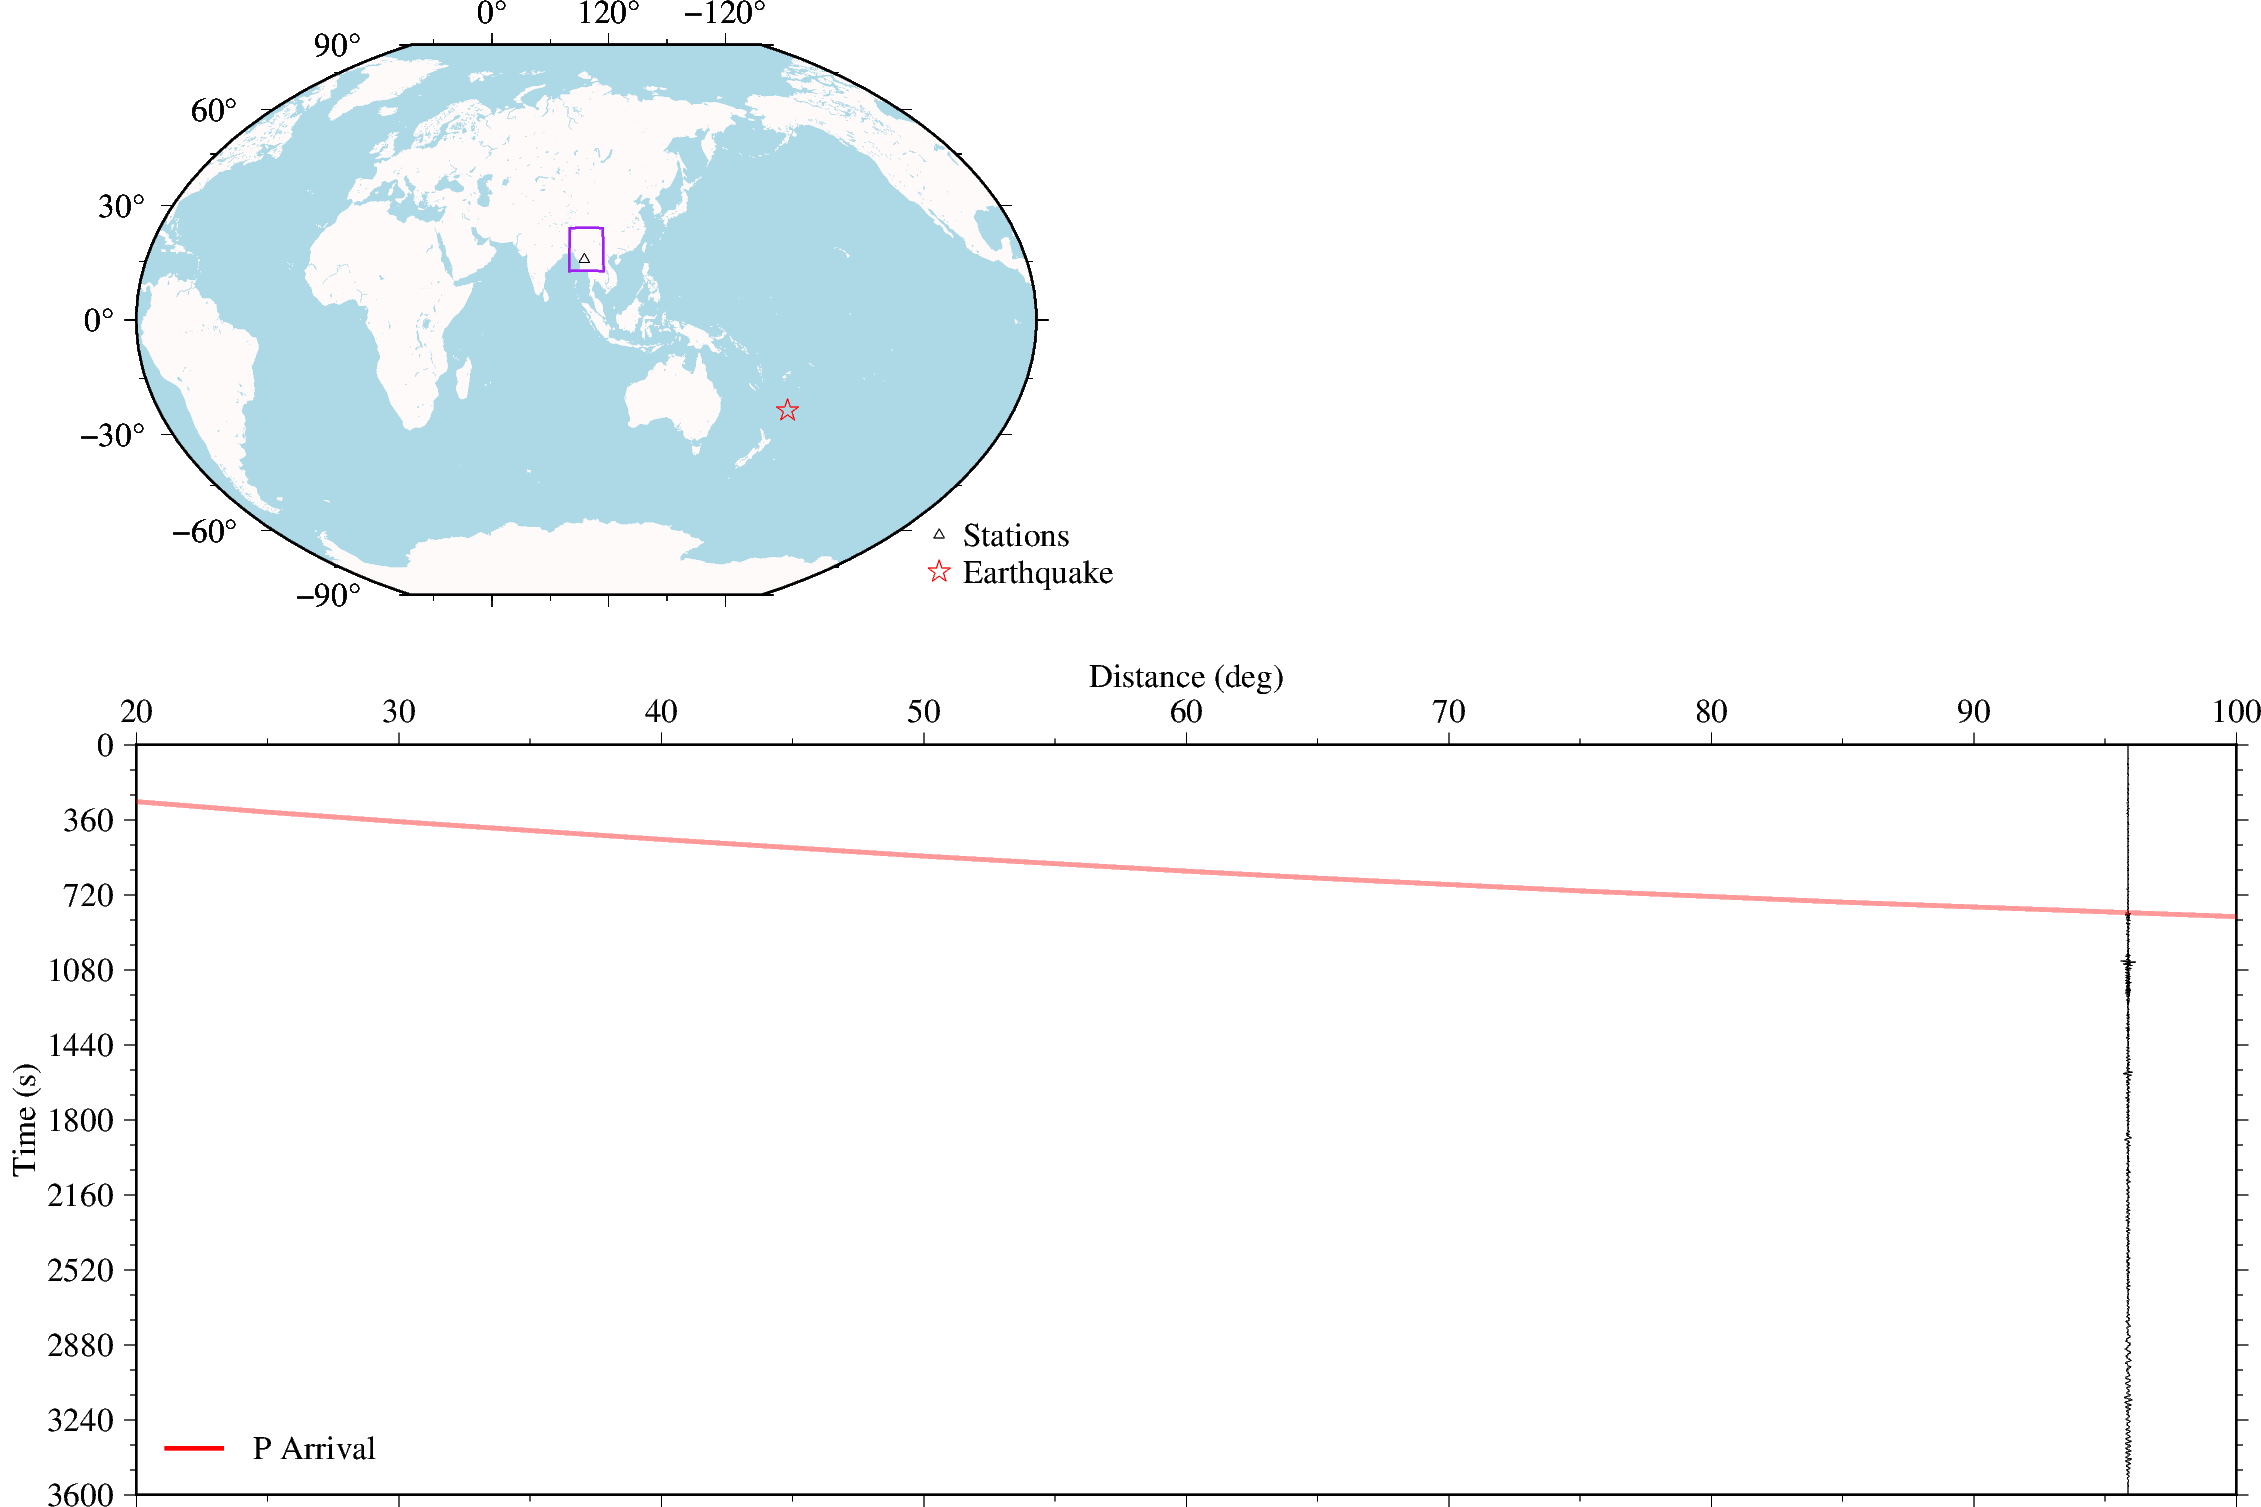

For Event: 20210529010241087


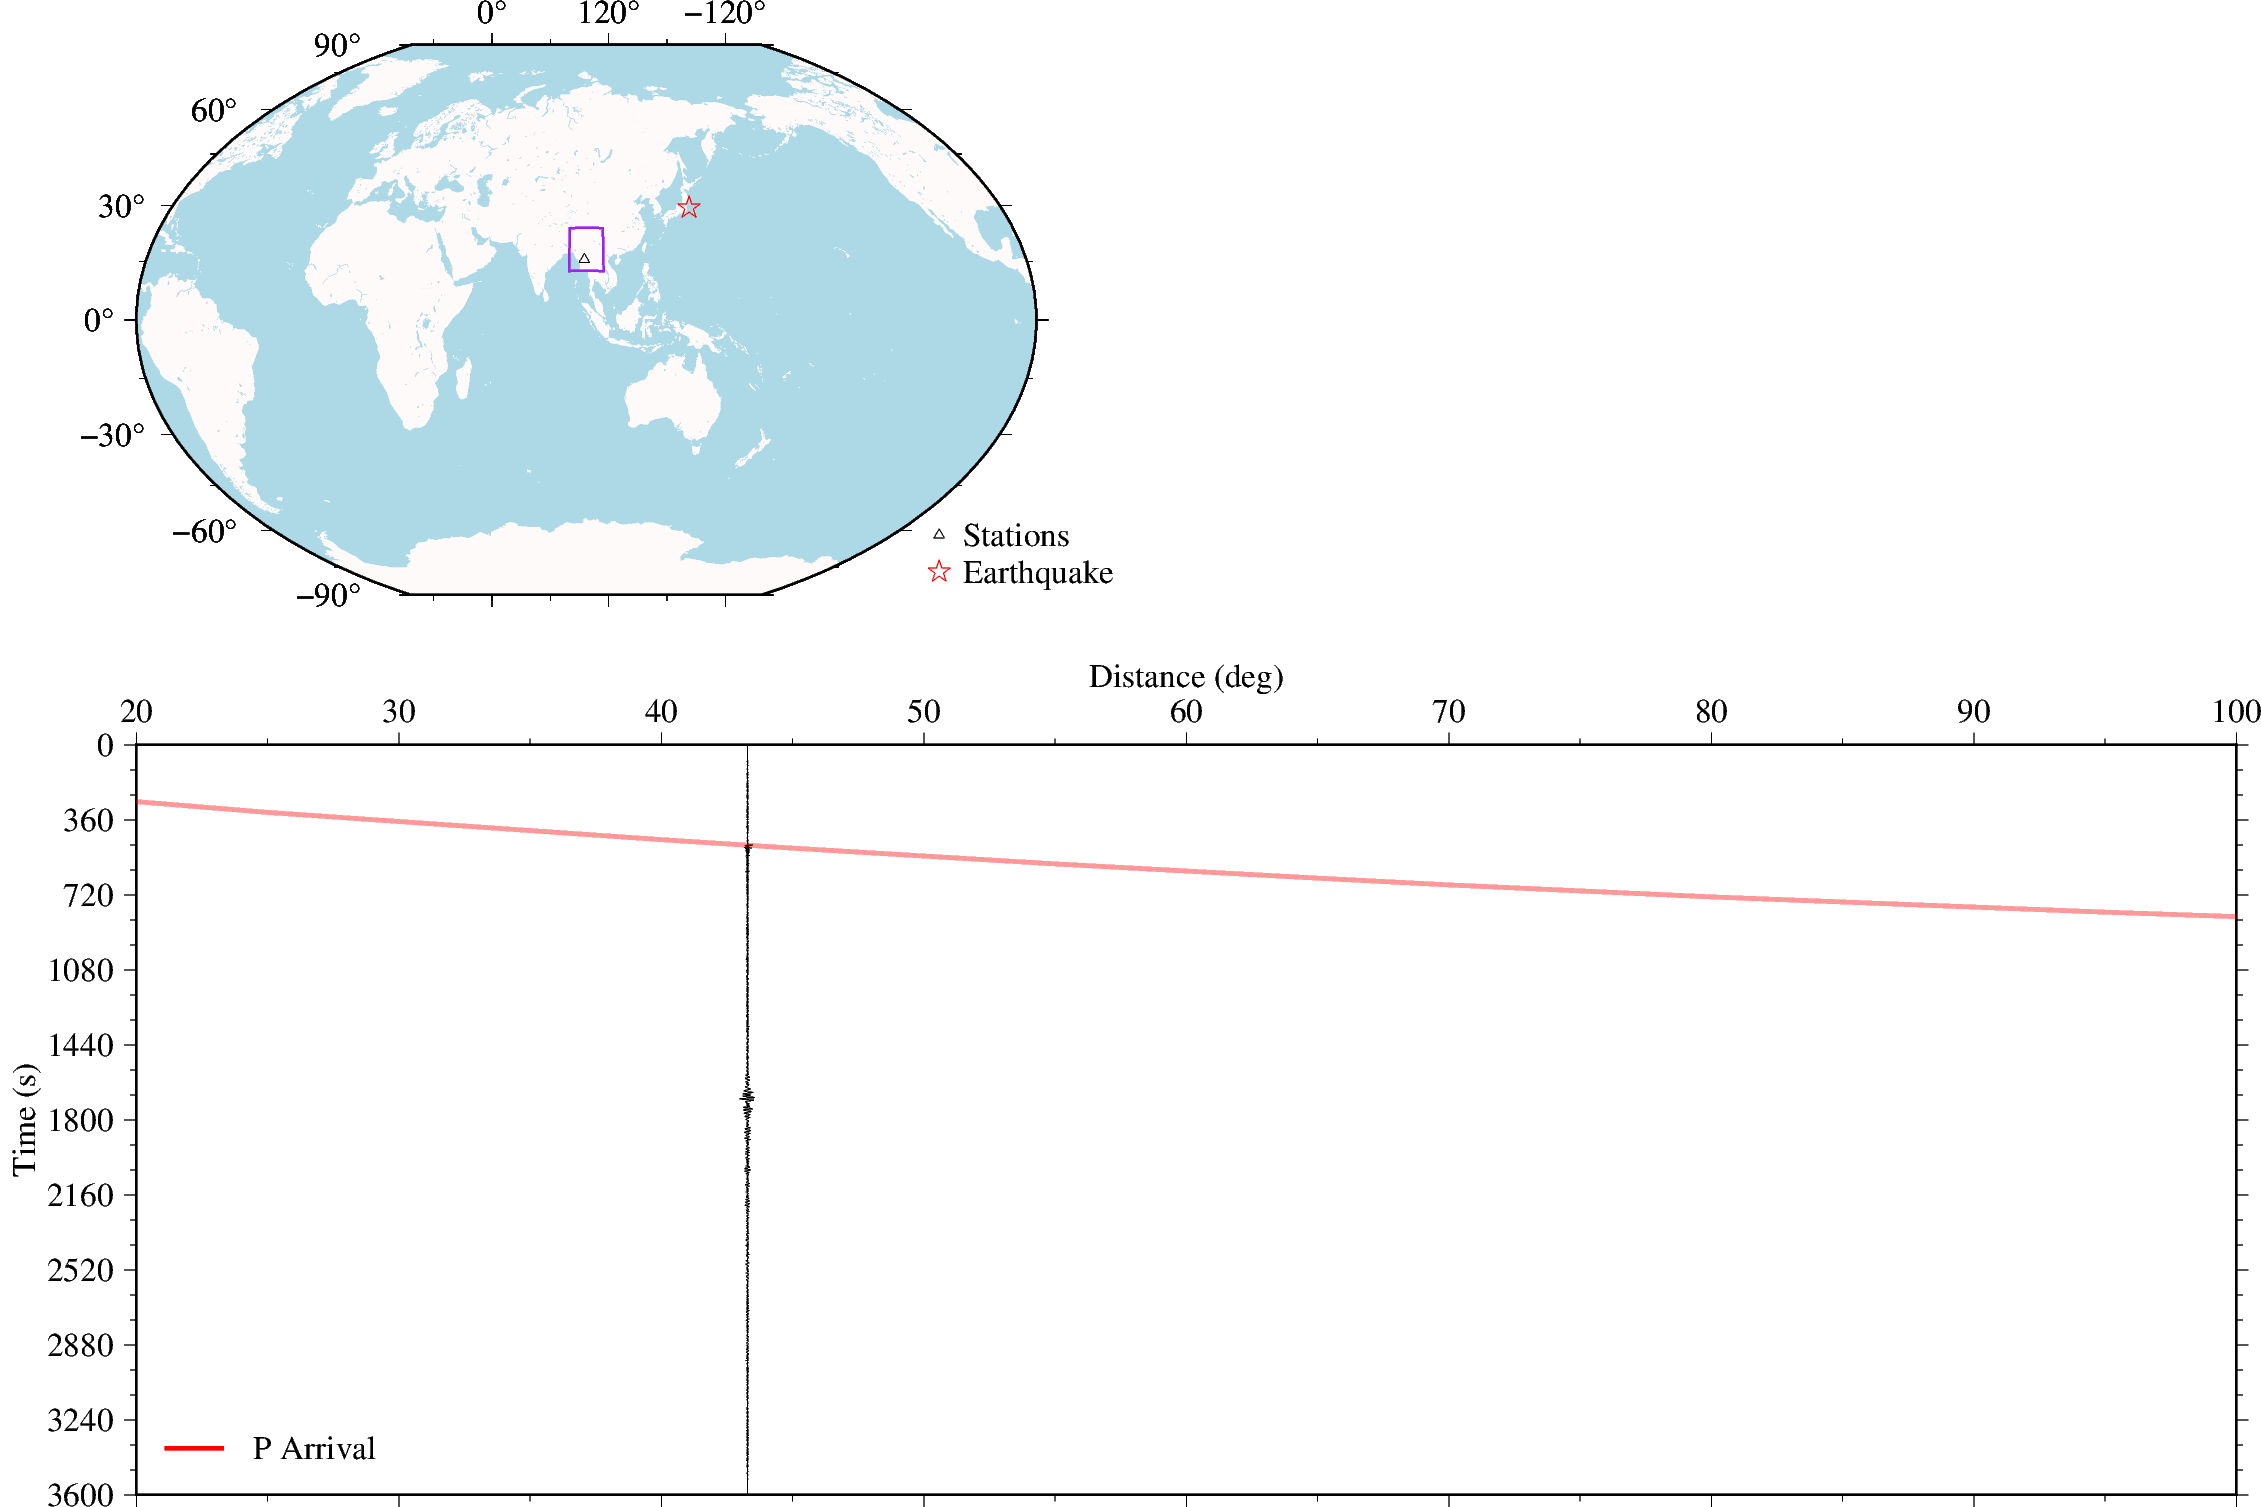

For Event: 20210124191234811


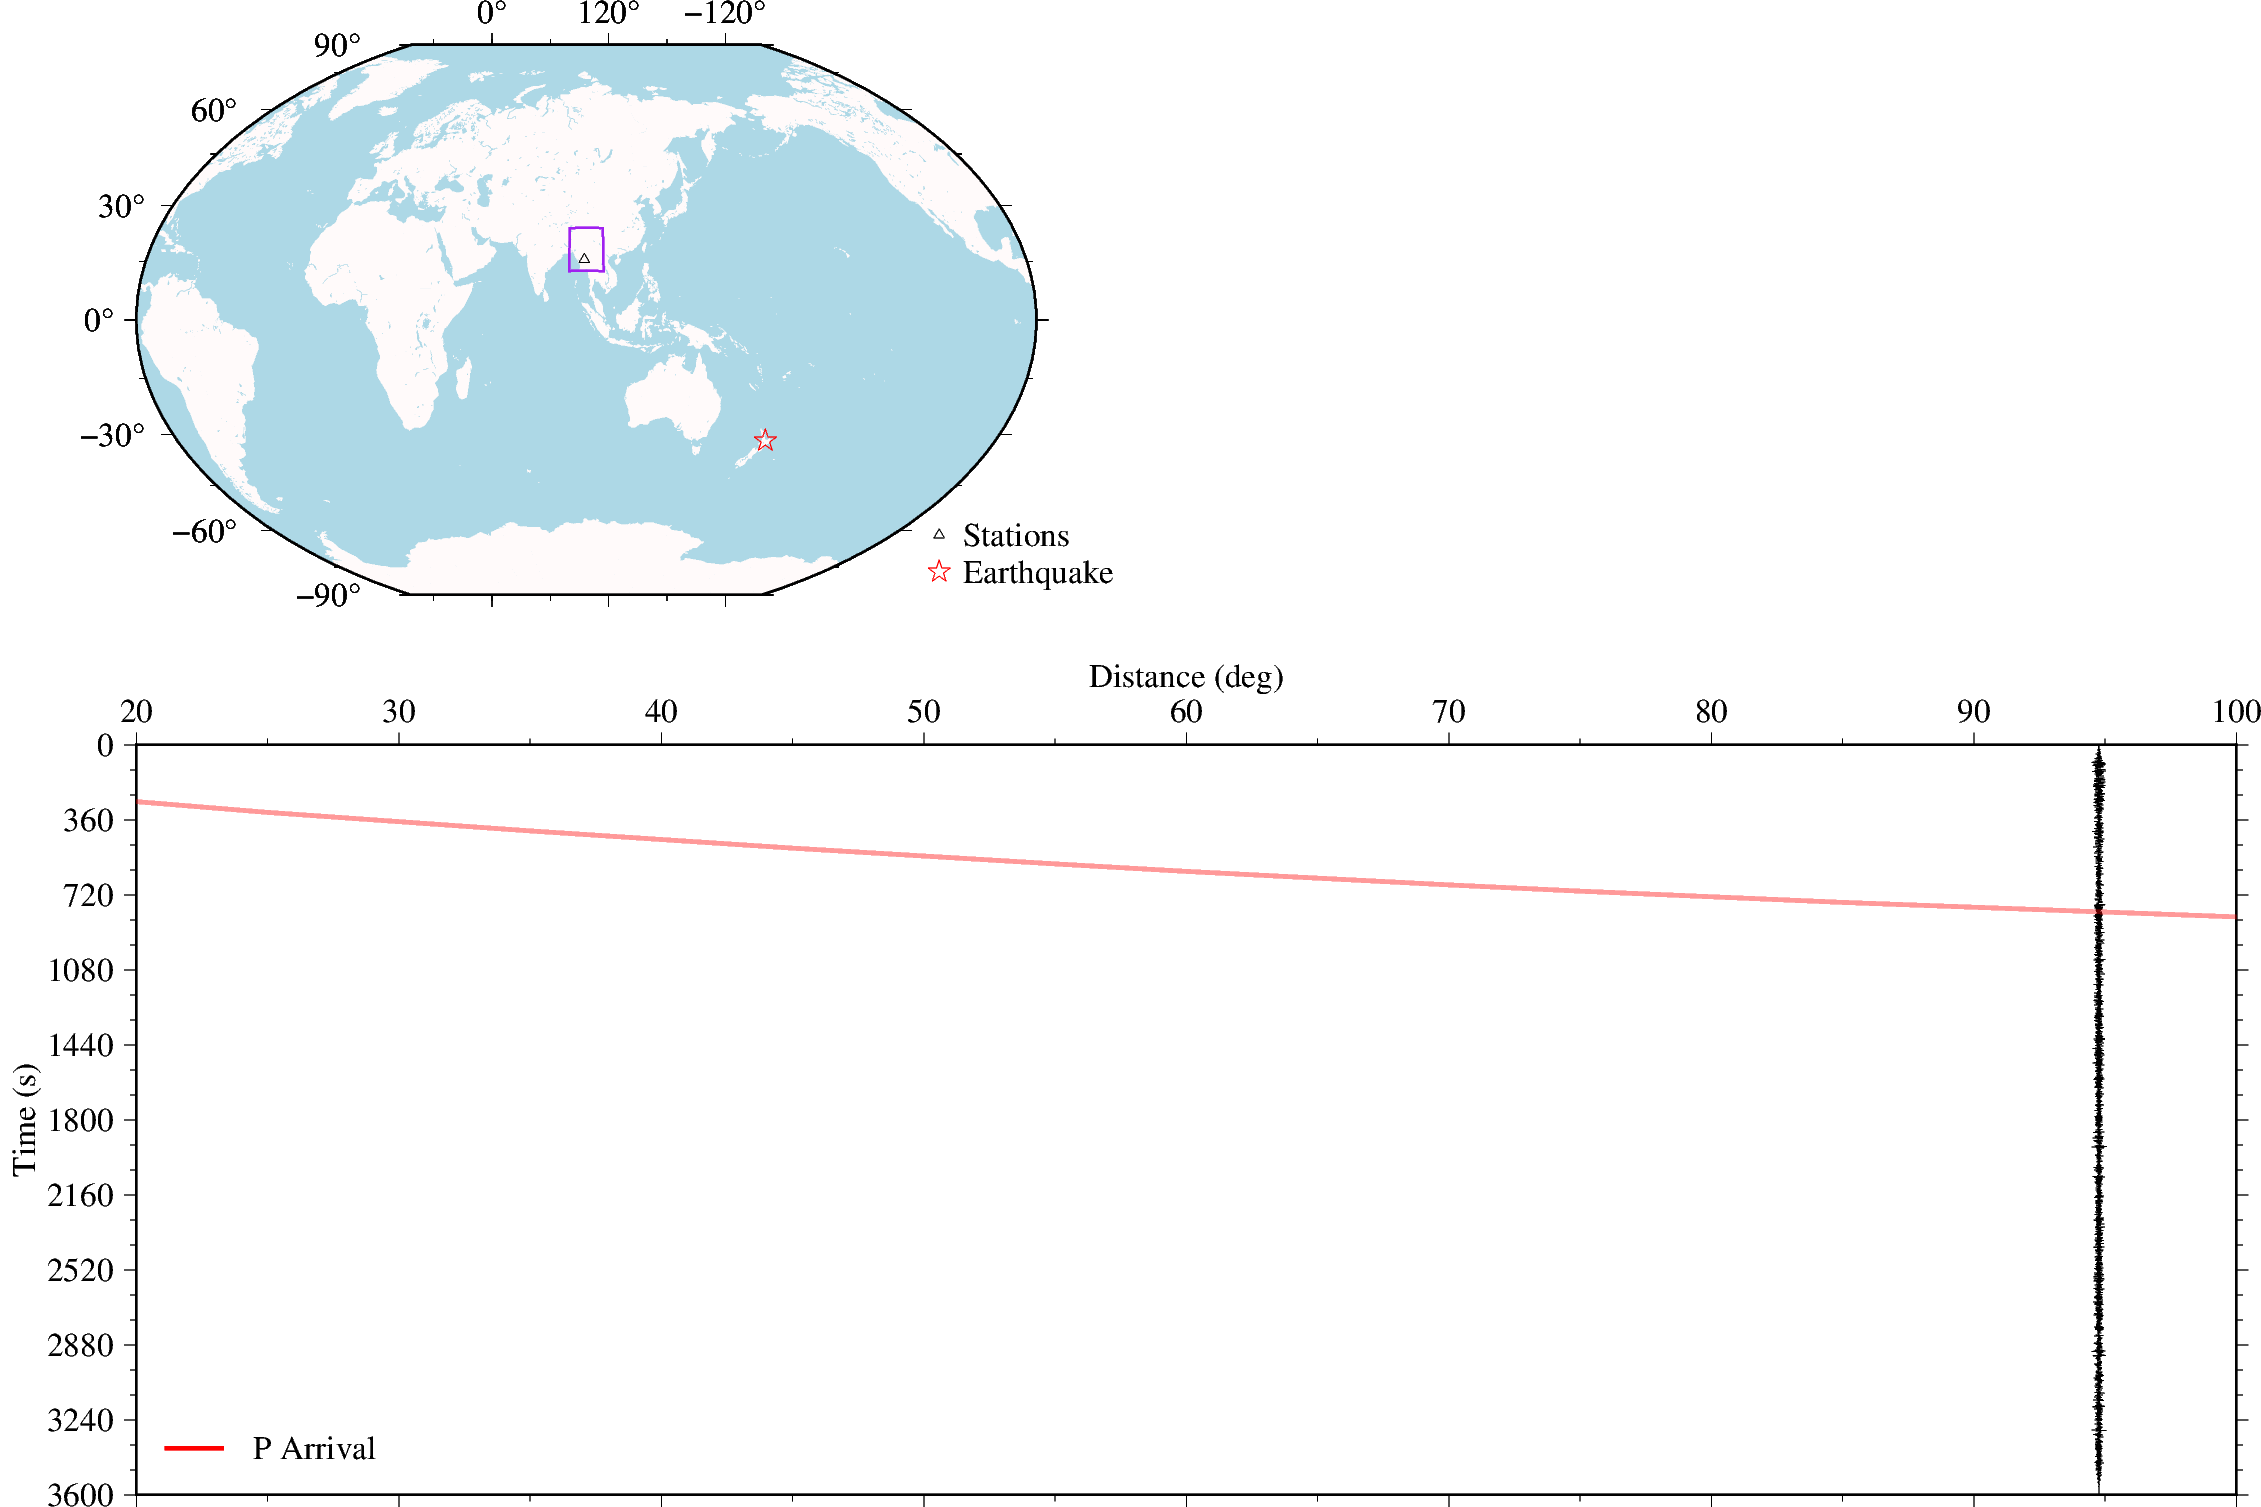

For Event: 20210306121204829
For Event: 20211002215926680


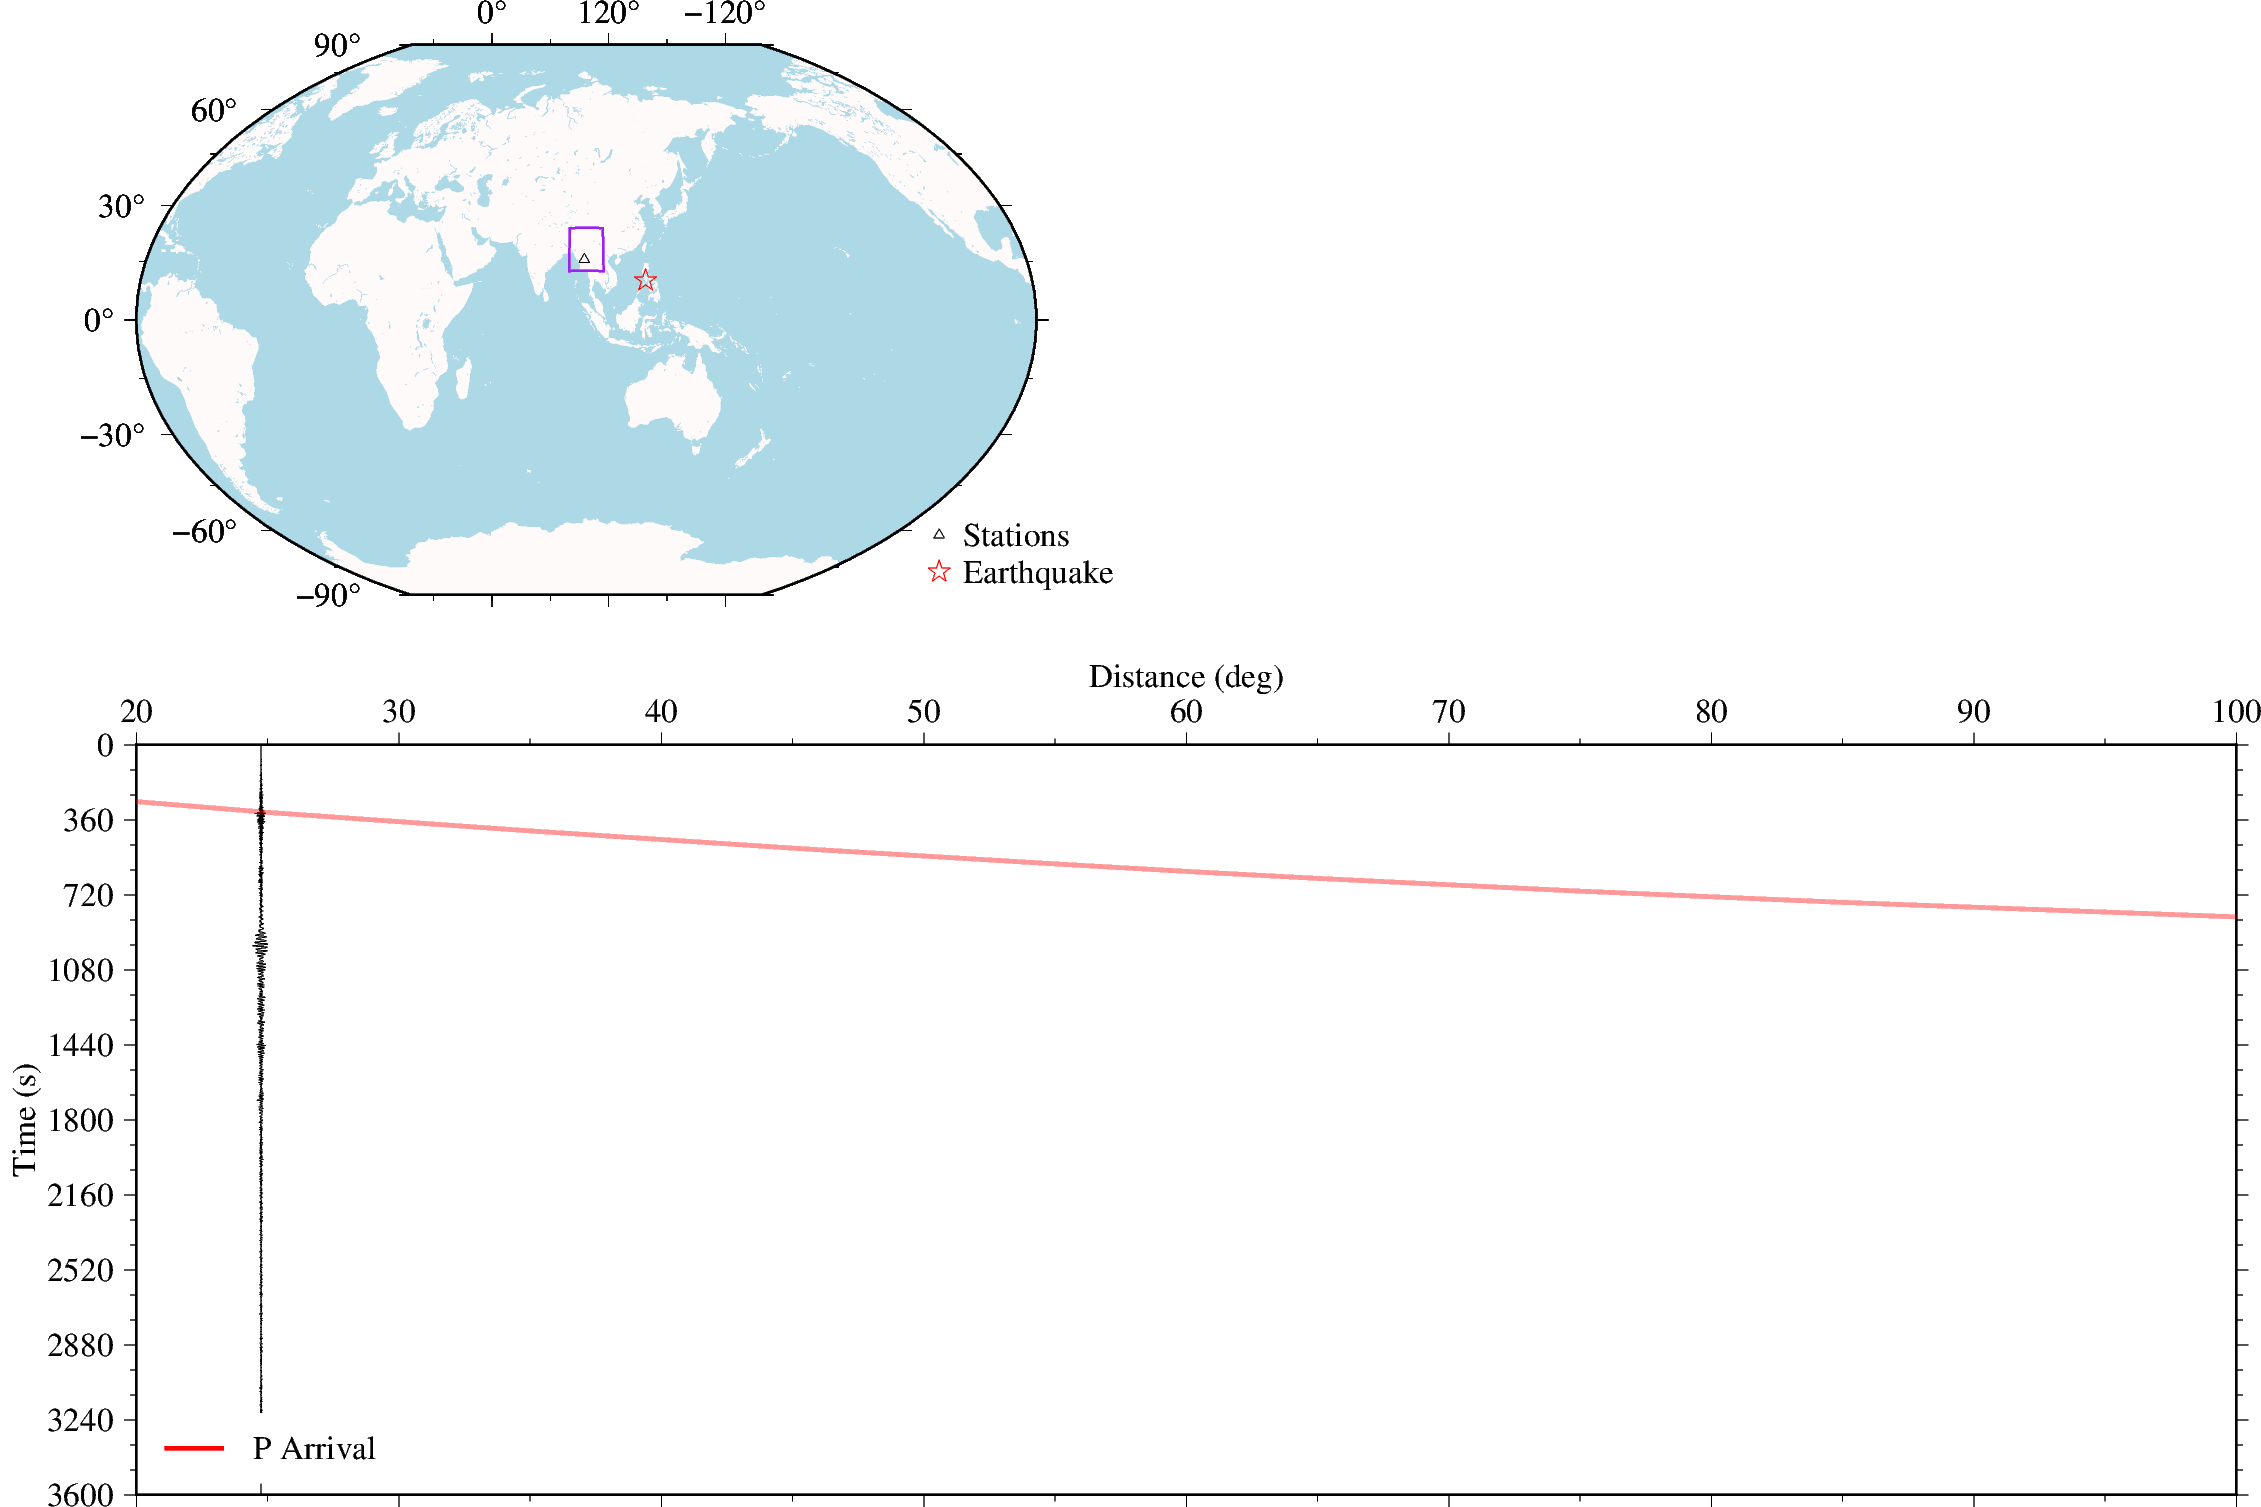

For Event: 20210908052004327


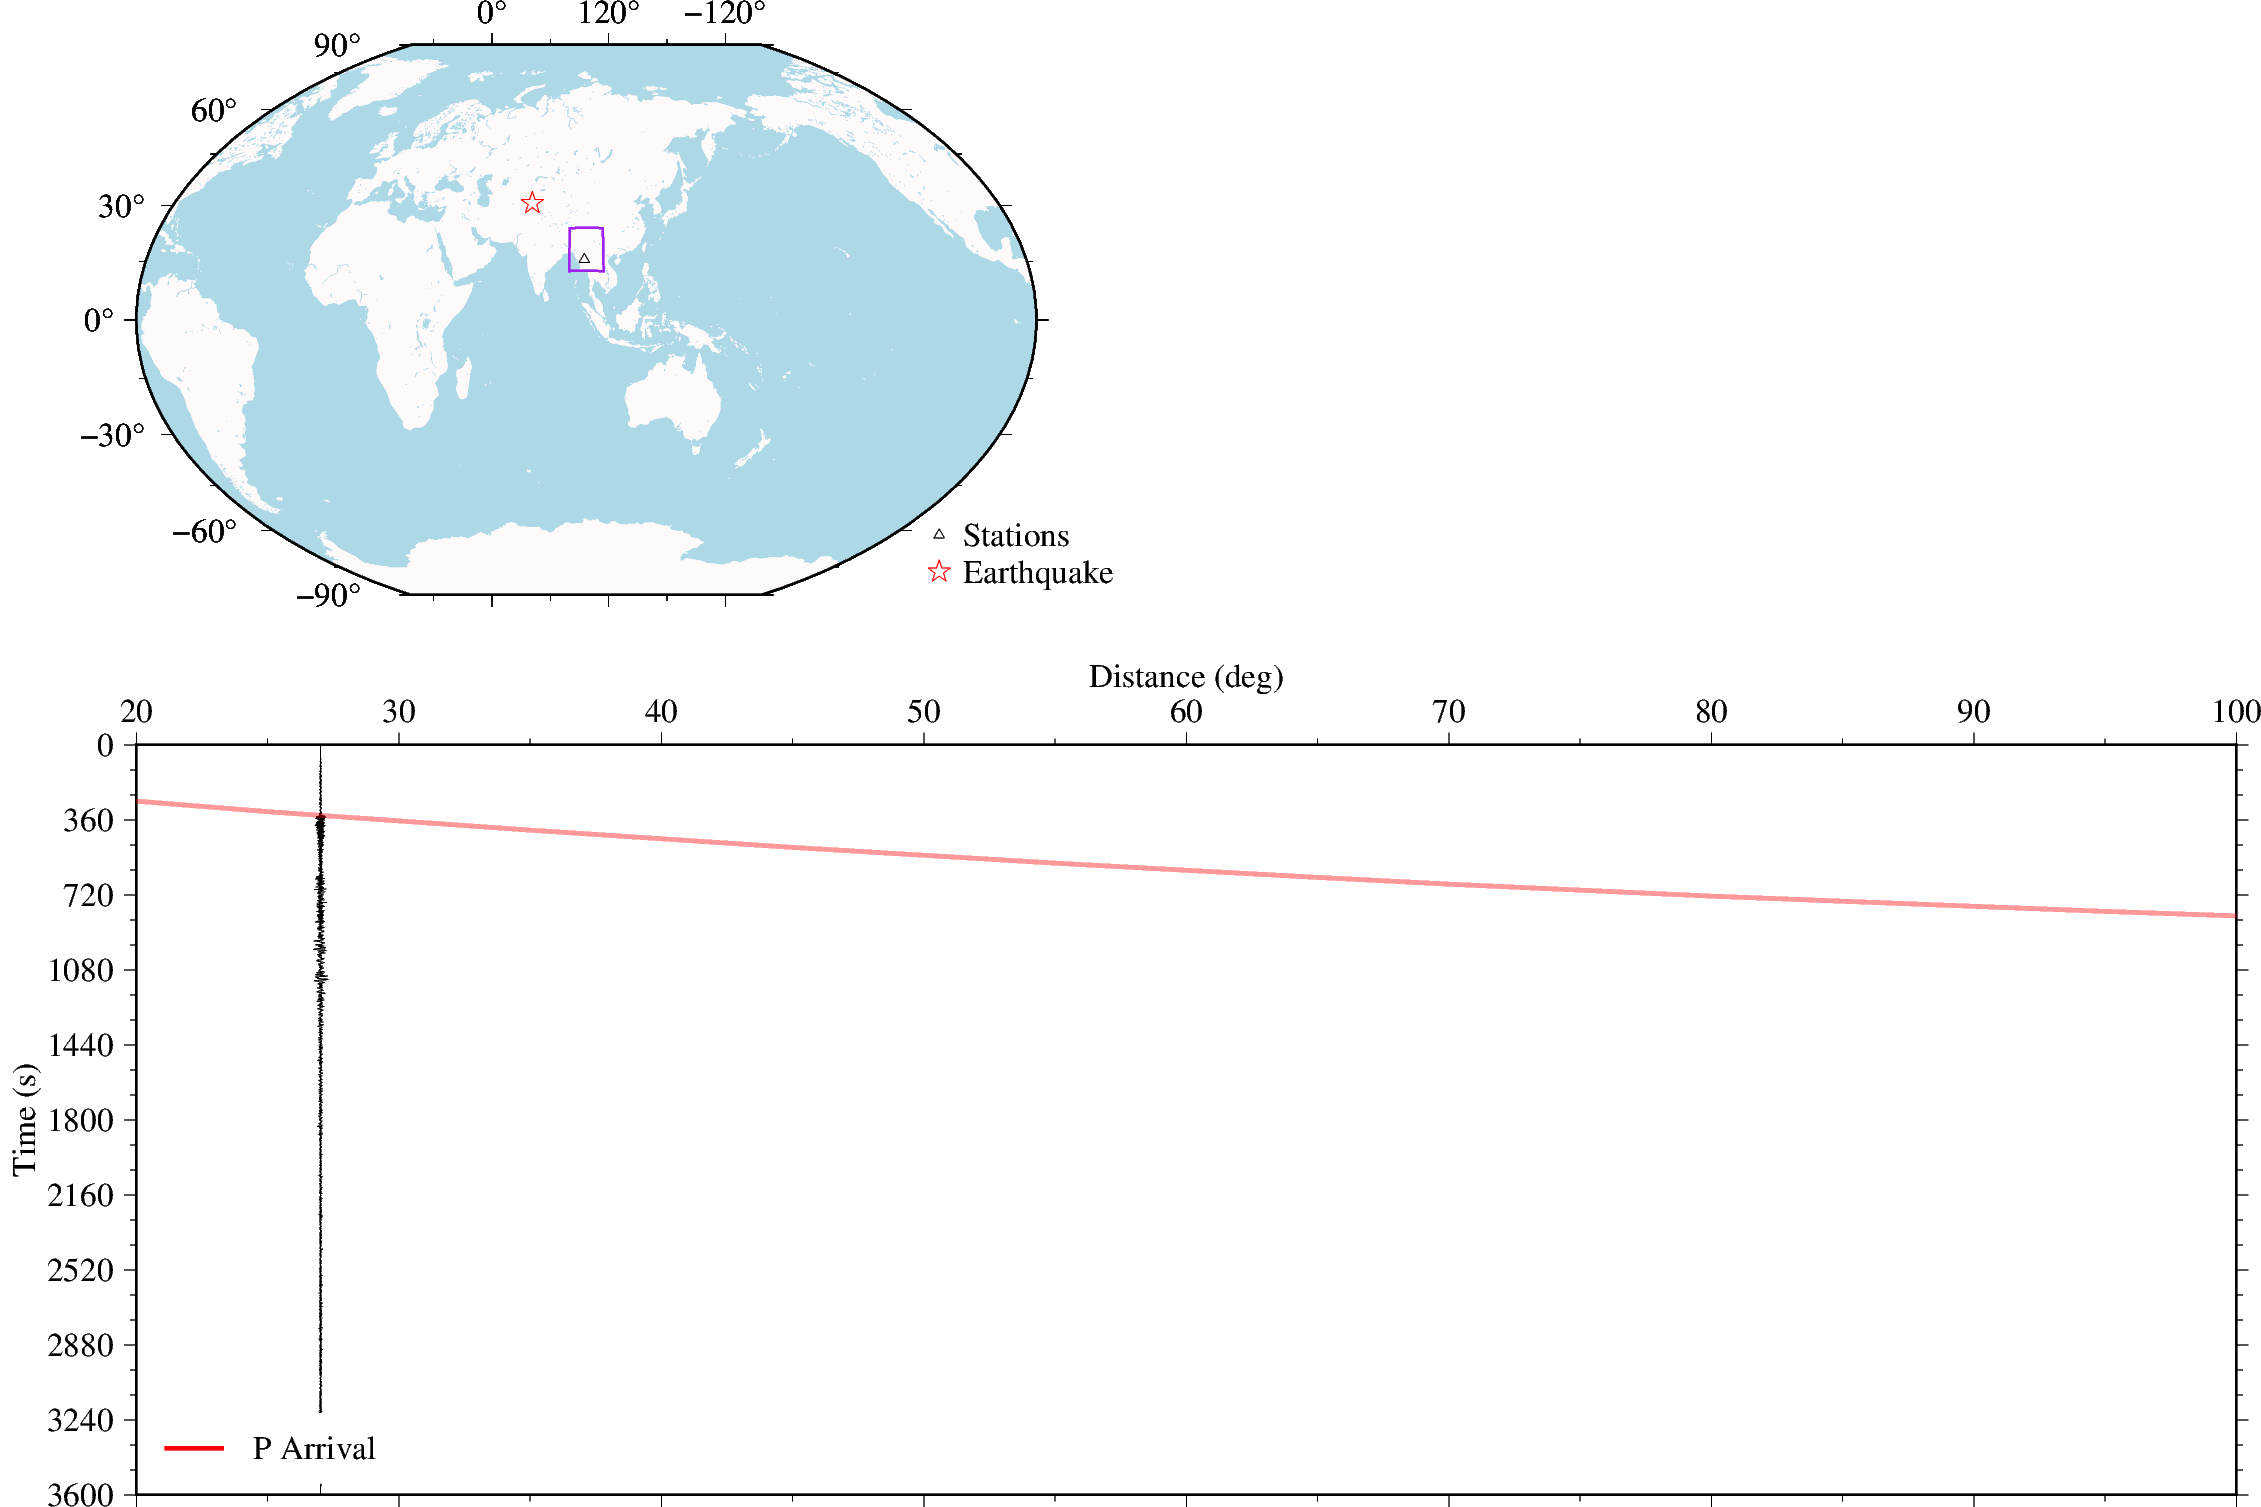

For Event: 20210211192039135


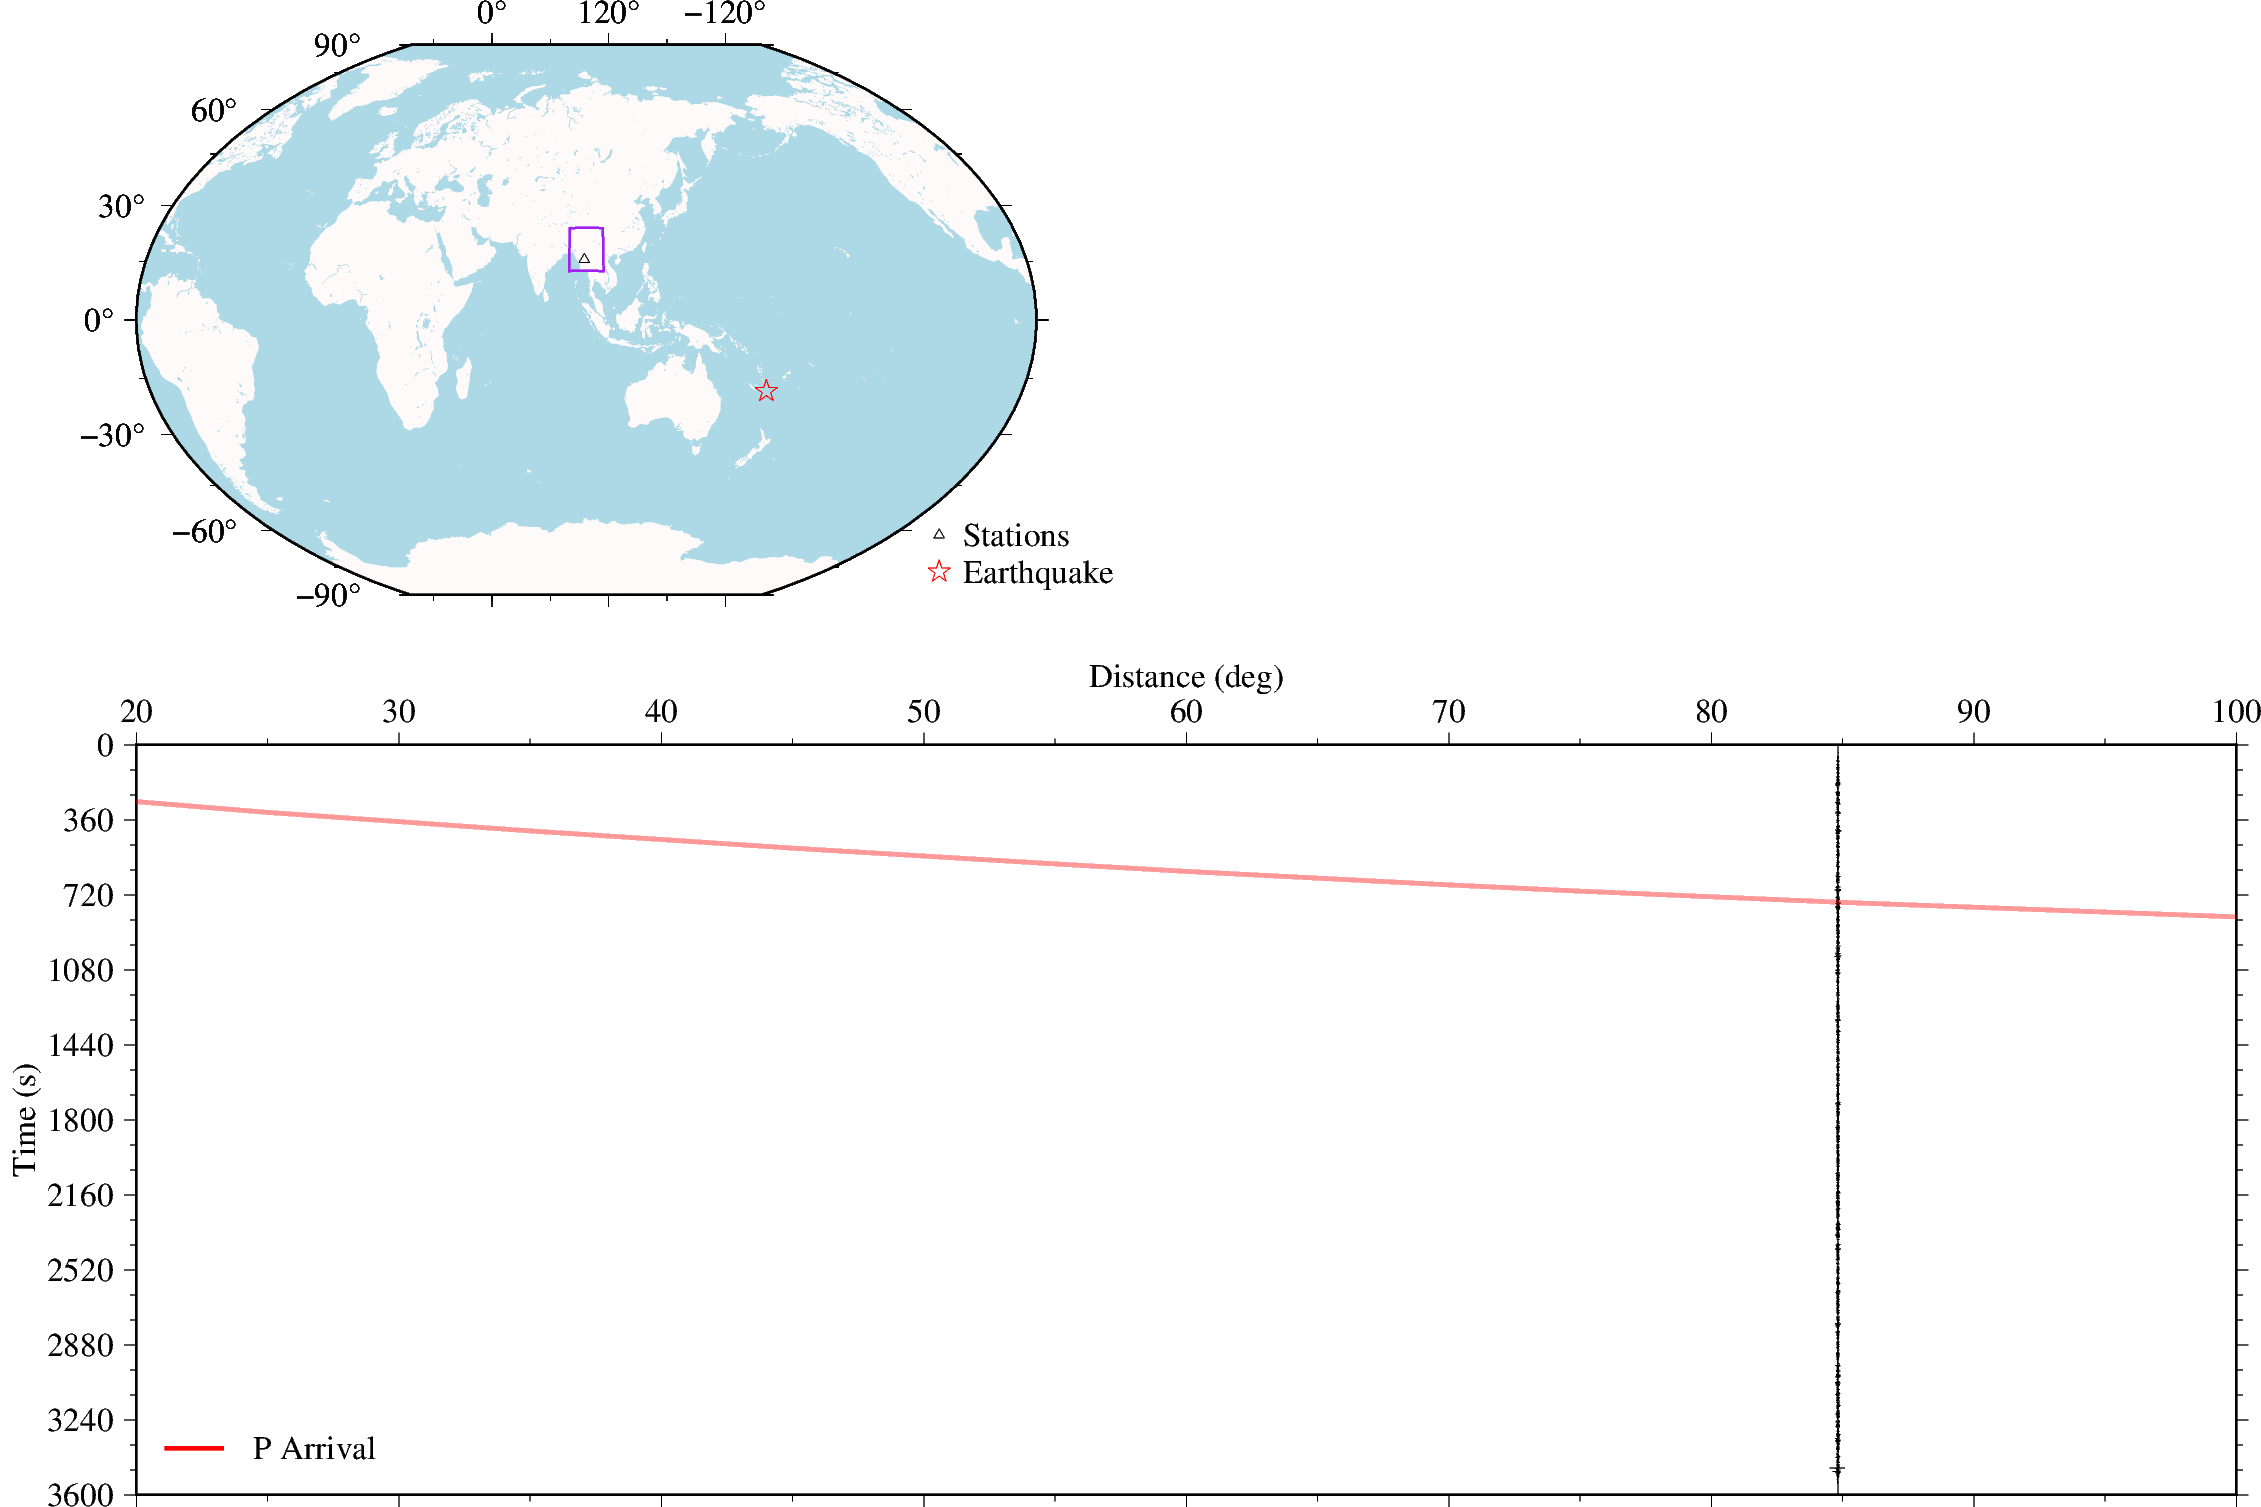

For Event: 20210516032353371


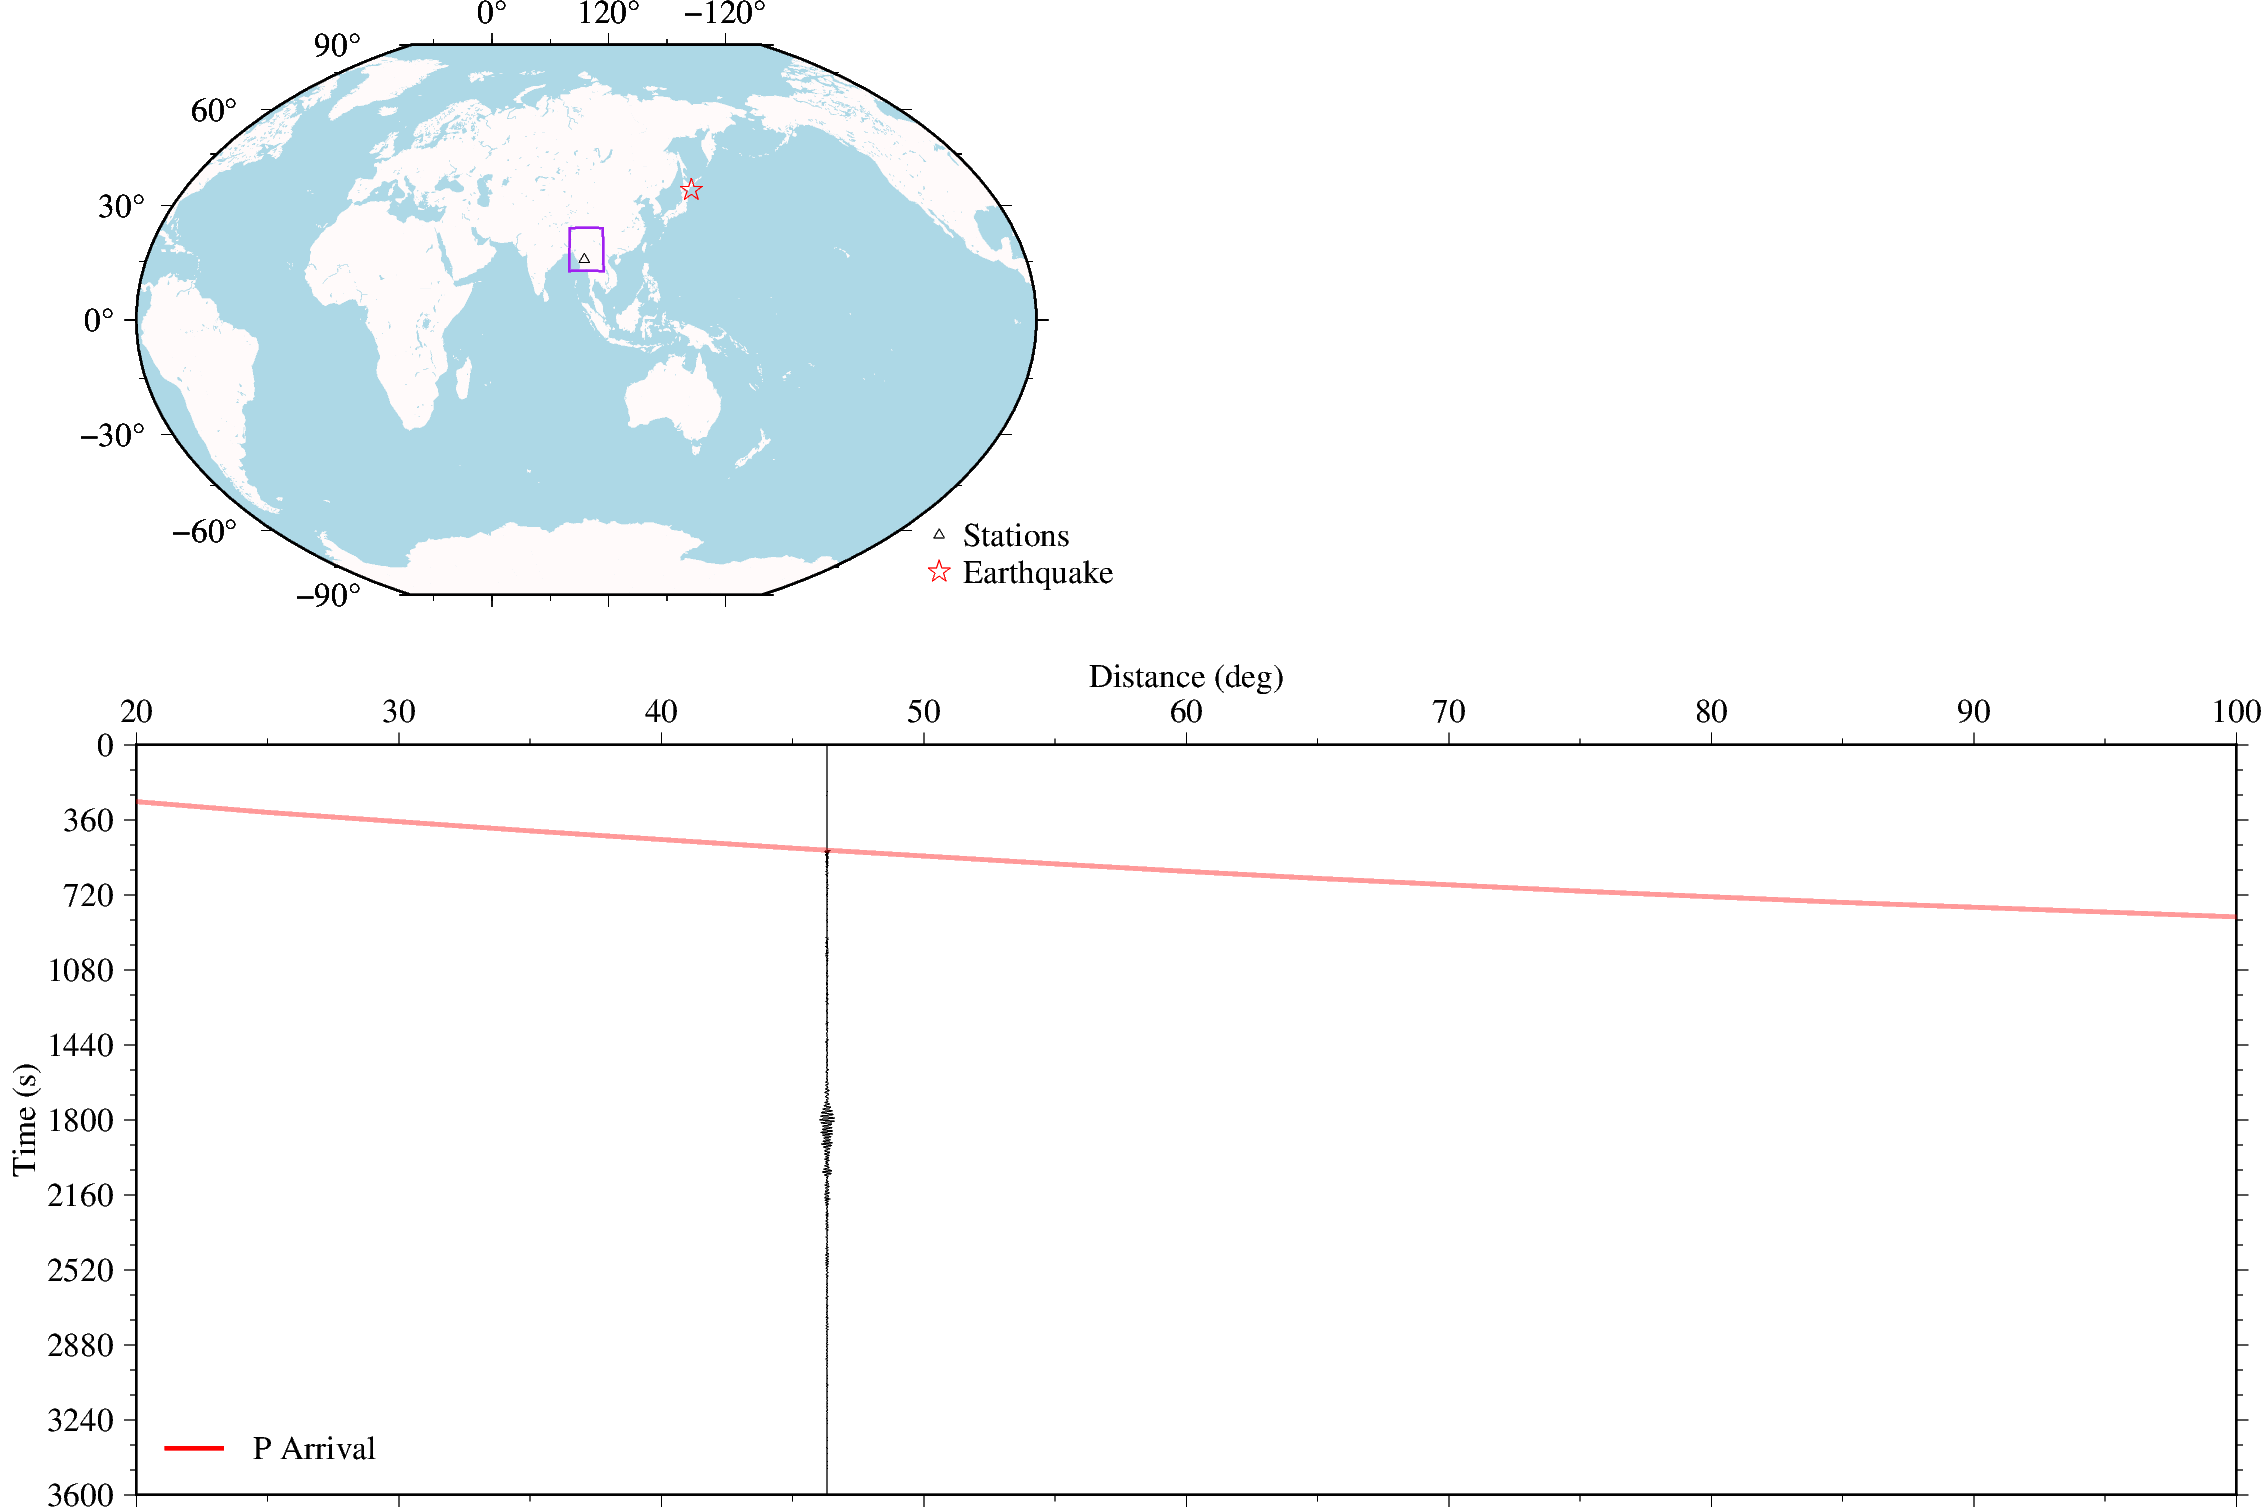

In [4]:
# Iterating over 25 events
j = 1
ev_considered = []

for ev in os.listdir(data_sac):
    try:
        print("For Event:", ev)
        ev_considered.append(ev)
        inpath = os.path.join(data_sac, ev)
        os.chdir(inpath)

        ### Plot the retained waveforms in event gather
        # Prepare the waveform files
        f = open("saclist","w")
        f.write("sacfile dist evdp mag Tp Tb stlo stla evlo evla\n")

        for sac in glob.glob(f"*.SAC.bp"):
            st = SACTrace.read(sac)
            evtnm = "{}.{}.{}.{}".format(str(sac).split(".")[0],str(sac).split(".")[1],str(sac).split(".")[2],str(sac).split(".")[3])
            dist = st.dist
            evdp = st.evdp
            mag = st.mag
            Tp = st.t1
            Tb = st.b
            stlo = st.stlo
            stla = st.stla
            evlo = st.evlo
            evla = st.evla

            f.write("%s %.0f %.1f %g %g %g %g %g %g %g\n" % (evtnm,dist,evdp,mag,Tp,Tb,stlo,stla,evlo,evla))
        f.close()

        ### Visualize
        ### Define your study region
        minlon, maxlon = 90, 104
        minlat, maxlat = 16, 30

        fig = pygmt.Figure()
        pygmt.config(MAP_FRAME_TYPE="plain",MAP_DEGREE_SYMBOL="degree",MAP_FRAME_WIDTH="0.2p",MAP_FRAME_PEN="0.5p",MAP_TICK_PEN_PRIMARY="0.1p",MAP_TICK_LENGTH_PRIMARY="0.1c")
        pygmt.config(FORMAT_GEO_MAP="dddD",IO_SEGMENT_MARKER="***")
        pygmt.config(FONT_LABEL="8p,4",MAP_LABEL_OFFSET="0.1c",FONT_ANNOT_PRIMARY="8p,4",FONT_TITLE="10p,4",FONT_HEADING="10p,4",MAP_HEADING_OFFSET="0.1c",MAP_TITLE_OFFSET="0.1c")

        df = pd.read_csv("saclist", sep=" ", usecols=["sacfile","dist","evdp","mag","Tp","Tb","stlo","stla","evlo","evla"])
        df = df.sort_values(by =['dist'])

        fig.basemap(region="g", projection="R97/3i", frame=['xa120f60+l"longitude"', 'ya30f15+l"latitude"', 'WsNe'])
        fig.coast(frame=['xa120f60+l"longitude"', 'ya30f15+l"latitude"', 'WsNe'], land="snow", water="lightblue")

        # Study area
        fig.plot(
            x=[minlon, minlon, maxlon, maxlon, minlon],
            y=[minlat, maxlat, maxlat, minlat, minlat],
            pen="0.5p,purple",
        )

        # Seismic stations
        fig.plot(x=df["stlo"],y=df["stla"],style="t0.1c",pen="0.1p,black",no_clip=True,
            label="Stations")

        # Seismic events
        fig.plot(x=df["evlo"],y=df["evla"],style="a0.2c",pen="0.1p,red",no_clip=True,
            label="Earthquake")

        fig.legend(position="jbr+o-0.8c/-0.1c")

        fig.basemap(region=[20, 100, 0, 3600], projection=f"X7i/-2.5i", 
            frame=['ya360f120+l"Time (s)"','xa10f5+l"Distance (deg)"','NWse'], yshift="-3.0i")

        with Session() as lib:
            bplst = []
            for i,file in enumerate(df['sacfile']):
                bplst.append("{}.SAC.bp".format(file))
            df["bp"] = bplst
            df[['bp','Tb']].to_csv('bp_dist',sep=" ",index=False)
            lib.call_module("pssac", "{} -Ed -Tt1 -M0.001 -W0.1p -Q -h1".format("bp_dist"))

        ### Prepare the traveltime curve
        model = TauPyModel(model="iasp91")
        gcarcu = []
        tp = []

        for gcarc in np.arange(10.0,105.0,5.0):
            gcarcu.append(gcarc)
            arrivals = model.get_travel_times(source_depth_in_km=df["evdp"][0],
                distance_in_degree=gcarc, phase_list=["ttp"])
            tp.append(arrivals[0].time)

        fig.plot(y=tp, x=gcarcu, pen="1p,red", transparency=60, label="P Arrival")
        fig.legend(position="jbl+o0.1c/0.1c",box="+gwhite")
        os.remove("bp_dist")

        fig.show()
    except:
        pass
    
    if j >= 25: break
    j += 1